# NCM, HVC Lesion Analysis

This notebook is used to compute the statistics and generate figures presented in the paper.

Final versions of the figures were post-processed in Adobe Illustrator.

When running this notebook with the `SAVE_FIGS` flag set to True, the EPS files of the figures will be saved to `FIGDIR = "notebooks/figures/svg_originals"`.

The statistics reported in the paper are printed out in the corresponding section, and (when possible) printed in the same format as in used in the paper. Statistics are rounded to 2 decimal places, and p-values are rounded to 4 decimal places (so that we can report 3 decimal places in the paper, or "< 0.001") 

## 1 Reading the data

Reading the data is facilitated by the class `zf_data.Tsvk`, which provides some helper methods to compute quantities used in the paper/figures. The name "Tsvk" refers to the term $T^{sv}_k$ from the methods used to compute $p(\mathrm{int}|s,v,k)$ --- that is the probability that subject $s$ interrupts a particular vocalizer $v$, given that it has seen $k$ informative trials of that vocalizer. 

Note that this data structure is not required for any analyses, since the raw data can be loaded directly from `zebra-finch-memory-lesions/data/behavior/TrialData.csv` and processed however you choose. However, it can be far more convenient to use this structure since it predefines methods used to perform the analyses found in the paper.

We also provide a helper functino `zf_data.load_trials()` for loading the TrialData.csv, which returns a pandas DataFrame containing all operant trials for all subjects.

```python
from zf_data import load_trials
df = load_trials()
```

## 2 Using the Tsvk data structure

A `Tsvk` instance is initialized with (1) a pandas DataFrame containing a filtered subset of operant trials, and (2) a value of `k_max`, the largest informative trial bin to include in the analysis.

```python
from zf_data import Tsvk
tsvk = Tsvk(df[(df.LesionStage == "prelesion") & (df.VocalizerSet == "S1")], k_max=11)
```

### Methods

Here are some of the helper methods `Tsvk` defines

* `tsvk.p(subject, vocalizer, k)`
    > Averages $p(\mathrm{int}|s,v,k)$ over vocalizers. Use `Tsvk.re.p(...)` and `Tsvk.nore.p(...)` to restrict it to either Re or NoRe vocalizers respectively.

* `tsvk.re.p_by_k()`, `Tsvk.nore.p_by_k()`
    > for each $k$, estimates $p(\mathrm{int}|Re,k)$ and $p(\mathrm{int}|NoRe,k)$ by jackknifing over subjects. These are used to produce the group average learning curves in Figure 3A and 3B.

* `tsvk.re.odds_by_subjects(k)`, `Tsvk.nore.odds_by_subjects(k)`
    > for each $k$, computes odds of interrupting Re or NoRe vocalizers of each subject

* `tsvk.logOR_by_subjects(k)`
    > for each $k$, compute
    $$
    \mathrm{logOR}(s, k)=\mathrm{log}(Odds(\mathrm{int}|s,NoRe,k)) - \mathrm{log}(Odds(\mathrm{int}|s,Re,k))
    $$
    for each subject, returning it in a pandas DataFrame

* `tsvk.logOR()`
    > Computes $\mathrm{logOR}(k)$ for $k \in \{0, .., k_{max}\}$. At each $k$, the estimate and SEM is estimated using a jackknife procedure over subjects, returning it in a pandas DataFrame. The condition $\mathrm{logOR}(k) > 0$ is tested with a one-sided paired t-test over subjects. The Benjamini-Hochberg false discovery correction used in the paper should be applied after calling this method.

* `tsvk.fisher_exact()`
    > Computes the result of a Fisher exact test on the entire DataFrame, with the following contingency matrix. The Fisher exact test returns the estimate of $\mathrm{OR}=\frac{ad}{bc}$, 95% confidence bounds on the estimate, and a p-value. 

|         |Interruptions|Waits|
|---------|:-:|:-:|
|NoRe     | a | c |
|Re       | b | d |

### Note on caching results

Computing the quantities used in the paper can be relatively slow (10s of seconds). Each `Tsvk` instance caches the result of most of its methods when they are called once, so that re-running a cell happens relatively instantaneously.

Sometimes multiple figures/analyses operate on the same subset of data (e.g. the top and bottom figures of Figure 3A and 3B). To avoid re-instantiating a `Tsvk` instance for each analysis (which would cause all the computations to be re-run), a function called `get_or_create_Tsvk` is defined in this notebook which restores a previous `Tsvk` instance if the dataframe and k_max parameter are identical.

## 3 Typical analysis pattern


The pattern used in this notebook is usually:

1. Instantiate a Tsvk object for one or more ranges of data (e.g. S1 & prelesion), e.g.

```python
tsvk = get_or_create_Tsvk(df[(df.LesionStage == "prelesion") & (df.VocalizerSet == "S1")], k_max=11)
```

2. Compute some quantity or quantities of interest, e.g.

```python
re_probabilities = tsvk.re.p_by_k()
nore_probailities = tsvk.nore.p_by_k()
```

3. Plot or perform statistics on the returned quantities, e.g.

```python
import matplotlib.pyplot as plt
plt.errorbar(re_probabilities.k, re_probabilities.logOR, y_err=2 * re_probabilities.SE)
plt.errorbar(nore_probabilities.k, nore_probabilities.logOR, y_err=2 * nore_probabilities.SE)
```

In [1]:
import os
import sys

In [2]:
os.chdir('/Users/frederictheunissen/Code/zebra-finch-memory-lesions/')

In [3]:
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import statsmodels
import statsmodels.api as sm
import statsmodels.regression
import statsmodels.formula.api as smf
from matplotlib.gridspec import GridSpec
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.oneway import anova_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from zf_data import Tsvk, load_trials
from zf_data.load_data import load_lesion_summary_table
from zf_data.plotting import (
    border,
    color_by_reward,
    draw_k_axis,
    draw_logor_axes_markers,
    draw_probability_axes_markers,
    plot_pecking_test_data,
    figure_cm,
    fig_grid,
    smoothhist,
    shaded_line,
)
from zf_data.stats import false_discovery, likelihood_ratio_test, two_to_one_tail
from zf_data.utils import parse_p, setup_mpl_params
from zf_data.constants import *

In [4]:
setup_mpl_params()

In [5]:
%load_ext autoreload
%autoreload 2

## Notebook settings

In [6]:
SAVE_FIGS = False  #@param {type: "boolean"}
FIGDIR = "figures/svg_originals"  #@param {type: "string"}
FIGDIR = Path(FIGDIR)

# Create the folder for figure outputs
FIGDIR.mkdir(parents=True, exist_ok=True)

def savedir(rel_path):
    """Return the save path relative to FIGDIR"""
    return str(FIGDIR / rel_path)

# JNeurosci column sizes in cm, see https://www.jneurosci.org/content/information-authors
COL1 = 8.5  #@param {type: "number"}
COL1_5 = 11.6  #@param {type: "number"}
COL2 = 17.6  #@param {type: "number"}

### Helper functions

In [7]:
def get_or_create_Tsvk(df: pd.DataFrame, k_max: int = None) -> Tsvk:
    """Create a Tsvk instance from a dataframe, or return a cached one for that data
    
    If the df.index and k_max match a previously computed Tsvk, return that one. Otherwise,
    instantiate a new Tsvk() instance.
    
    Tsvk instances are hashed by a tuple of the dataframe index and k_max requested.
    """
    key = (tuple(df.index), k_max)
    if key not in get_or_create_Tsvk.cache:
        get_or_create_Tsvk.cache[key] = Tsvk(df, k_max=k_max)
    return get_or_create_Tsvk.cache[key]
get_or_create_Tsvk.cache = {}

def test_get_or_create_Tsvk(df: pd.DataFrame):
    backup = get_or_create_Tsvk.cache.copy()
    get_or_create_Tsvk.cache = {}
    t1 = get_or_create_Tsvk(df[(df.LesionStage == "prelesion") & (df.VocalizerSet == "S1")], k_max=11)
    t2 = get_or_create_Tsvk(df[(df.LesionStage == "prelesion") & (df.VocalizerSet == "S1")], k_max=11)
    t3 = get_or_create_Tsvk(df[(df.LesionStage == "prelesion") & (df.VocalizerSet == "S1")], k_max=12)
    t4 = get_or_create_Tsvk(df[(df.LesionStage == "postlesion") & (df.VocalizerSet == "S2")], k_max=12)
    
    assert t1 is t2
    assert t1 is not t3
    assert t2 is not t3
    assert t1 is not t4
    assert t2 is not t4
    print("Tests pass")
    
    get_or_create_Tsvk.cache = backup
    

## Load data

In [8]:
df = load_trials()

In [9]:
test_get_or_create_Tsvk(df)

Tests pass


## Speaker output problems

Sessions on Nov 20, 2020 had technical issues with audio output where speakers in two subjects (BluWhi3230M, HVC) and (GreWhi2703M, HVC), where audio stopped playing audio partway through the session. Four subjects were affected, all in the HVC group, and the sessions were postlesion S1 for 6v6-d2 DCs (BluWhi3230M) and 8v8-d2 Songs (GreWhi2703M). Audio went out at about 12:00. We exclude data on this day after this time.

Here I load that extra data and plot it to show what data is excluded.

In [10]:
from zf_data.load_data import EXCLUSION_SUBJECTS, EXCLUSION_DATE, EXCLUSION_TIME
full_df = load_trials(valid_only=False)

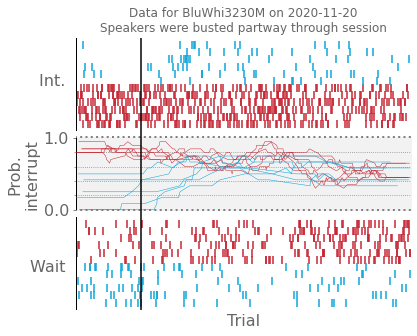

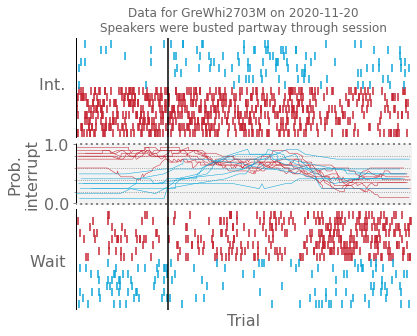

In [11]:
for subject in EXCLUSION_SUBJECTS:
    subj_df = full_df[(full_df.Date == EXCLUSION_DATE) & (full_df.Subject == subject)]
    exclusion_df = full_df[
        (full_df.Date == EXCLUSION_DATE)
        & (full_df.Time > EXCLUSION_TIME)
        & (full_df.Subject == subject)
    ]
    exclusion_first_index = exclusion_df.Trial.iloc[0]
    
    fig = plot_pecking_test_data(
        subj_df,
        ["StimulusClass", "StimulusVocalizerId", "StimulusCallType"],
        ticks=True,
        figsize=(6, 5),
        linekwargs={"linewidth": 0.5},
        mark_days=True
    )
    plt.vlines([exclusion_first_index], *plt.ylim(), color="Black", label="Speakers stopped playing audio after")
    plt.title(f"Data for {subject} on 2020-11-20\nSpeakers were busted partway through session")
    plt.show()
    plt.close(fig)

## Figure 1

Figure 1 shows general task information and lesion images, and is not generated by this notebook.

## Figure 2

Figure 2 shows trial-by-trial data for two example subjects.

We'll show data from before lesion (S1) and after lesion (S1 and S2) for two subjects, named "XXXOra0037M" and "GreWhi2703M".

In [12]:
def figure2(subject):
    subject_df = df[df.Subject == subject]
    
    fig = plot_pecking_test_data(
        subject_df[
            (subject_df.VocalizerSet == "S1")
            & (subject_df.LesionStage == "prelesion")
        ],
        ["StimulusClass", "StimulusVocalizerId", "StimulusCallType"],
        ticks=False,
        figsize=(6, 3),
        linekwargs={"linewidth": 0.5},
        mark_days=True
    )
    if SAVE_FIGS:
        fig.savefig(savedir("fig2B-1.svg"), format="svg", bbox_inches="tight")
    plt.show()
    plt.close(fig)

    # Postlesion recall
    date_df = subject_df[
        (subject_df.VocalizerSet == "S1")
        & (subject_df.LesionStage == "postlesion")
    ]

    fig = plot_pecking_test_data(
        date_df,
        ["StimulusClass", "StimulusVocalizerId", "StimulusCallType"],
        ticks=False,
        figsize=(4, 3),
        linekwargs={"linewidth": 0.5},
        mark_days=True
    )
    if SAVE_FIGS:
        fig.savefig(savedir("fig2B-2.svg"), format="svg", bbox_inches="tight")
    plt.show()
    plt.close(fig)

    # Postlesion learning
    date_df = subject_df[
        (subject_df.VocalizerSet == "S2")
        & (subject_df.LesionStage == "postlesion")
    ]

    fig = plot_pecking_test_data(
        date_df,
        ["StimulusClass", "StimulusVocalizerId", "StimulusCallType"],
        ticks=False,
        figsize=(6, 3),
        linekwargs={"linewidth": 0.5},
        mark_days=True
    )
    if SAVE_FIGS:
        fig.savefig(savedir("fig2B-3.svg"), format="svg", bbox_inches="tight")

    plt.show()
    plt.close(fig)

-------------------------   BlaGre1349M   -----------------------


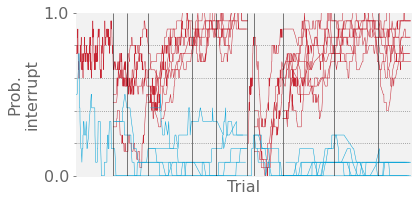

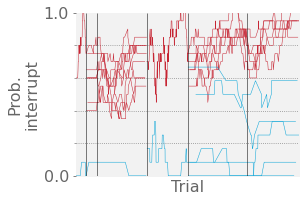

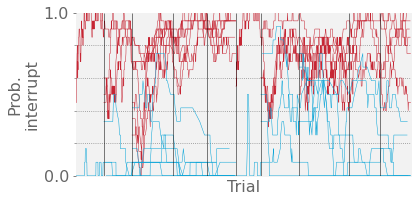

-------------------------   XXXBlu0031M   -----------------------


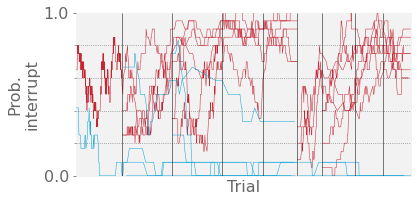

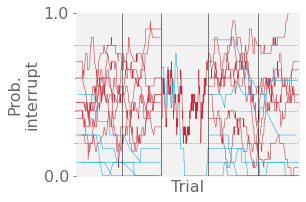

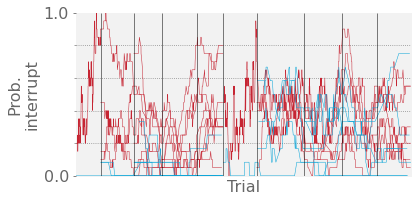

-------------------------   HpiGre0651M   -----------------------


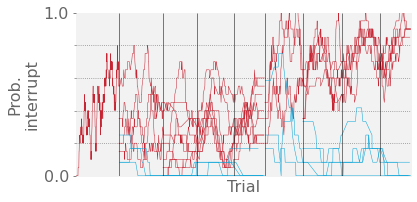

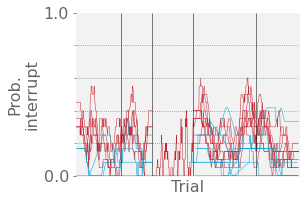

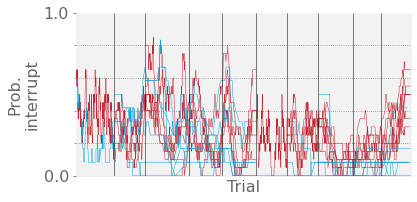

-------------------------   GreBla3404M   -----------------------


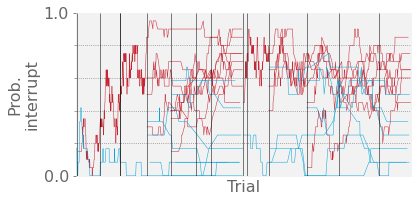

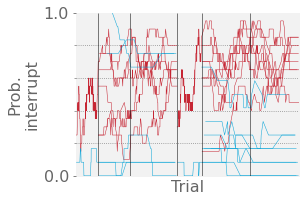

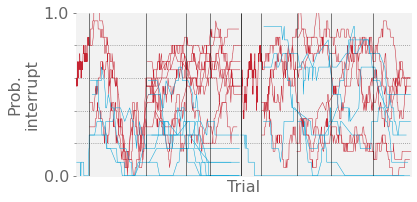

-------------------------   GreBlu5039F   -----------------------


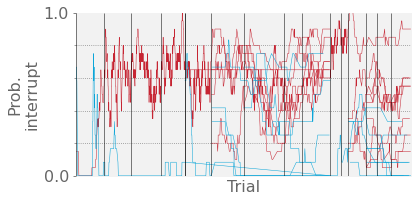

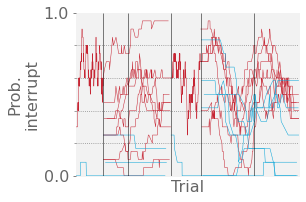

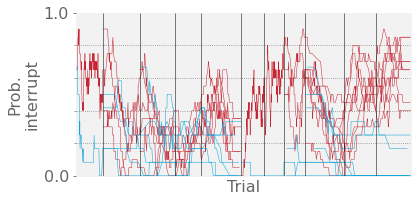

-------------------------   WhiBlu5805F   -----------------------


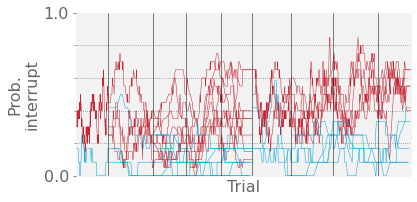

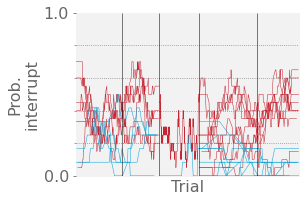

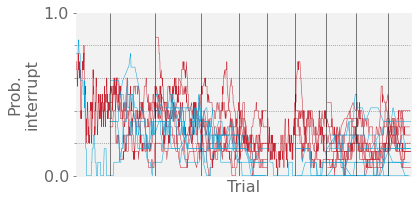

-------------------------   RedHpi0710F   -----------------------


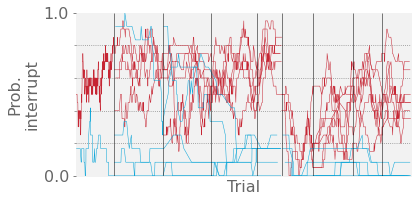

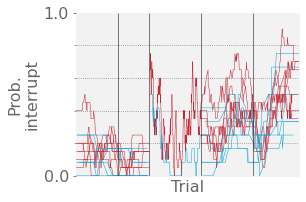

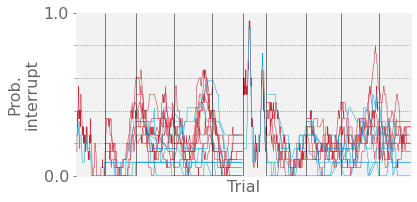

-------------------------   XXXOra0037F   -----------------------


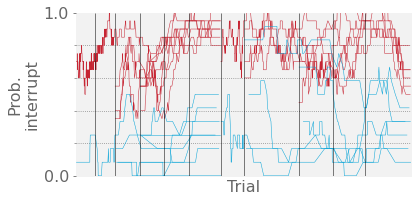

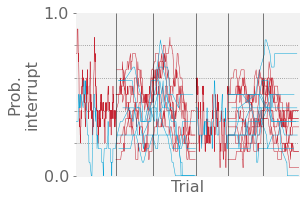

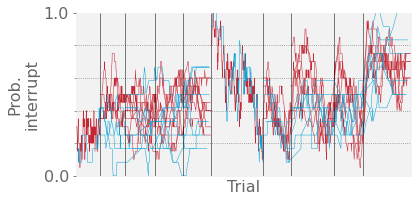

-------------------------   XXXHpi0038M   -----------------------


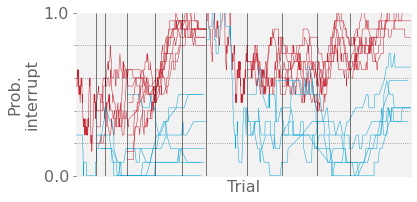

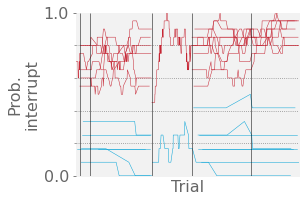

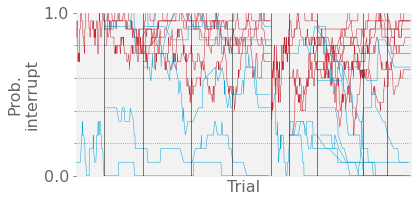

-------------------------   GraWhi4040F   -----------------------


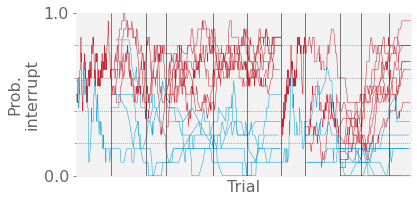

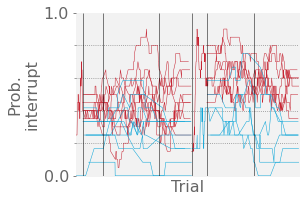

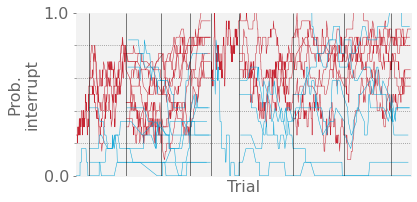

In [17]:
ncmBirds = ['BlaGre1349M', 'XXXBlu0031M', 'HpiGre0651M', 'GreBla3404M', 'GreBlu5039F', 'WhiBlu5805F',
            'RedHpi0710F', 'XXXOra0037F', 'XXXHpi0038M', 'GraWhi4040F']

for bird in ncmBirds:
    print('-------------------------  ', bird, '  -----------------------')
    figure2(bird)  

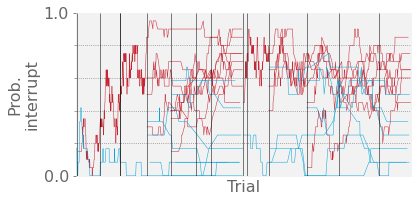

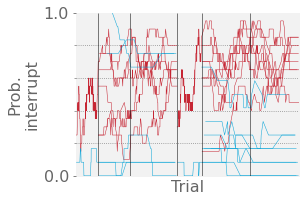

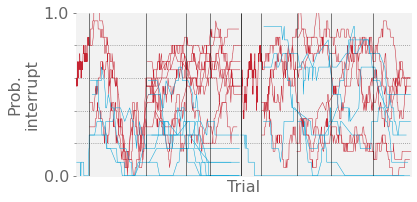

In [12]:
SAVE_FIGS = True
figure2("GreBla3404M")  # Example of Fig1 that also illustrates some relearning
SAVE_FIGS = False

-------------------------   BluWhi0398F   -----------------------


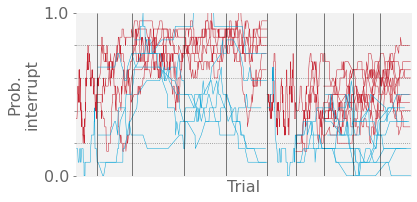

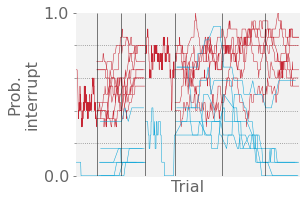

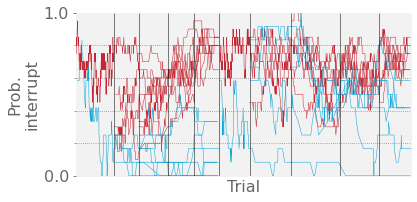

-------------------------   BluWhi3230M   -----------------------


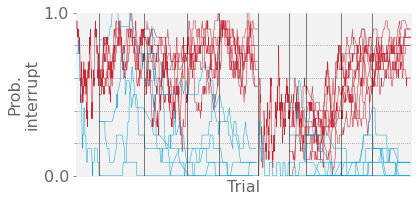

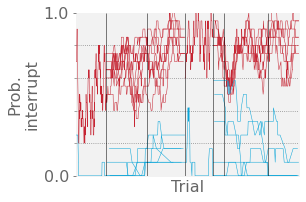

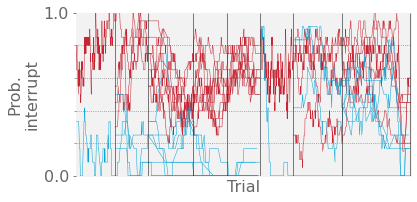

-------------------------   GraYel7337F   -----------------------


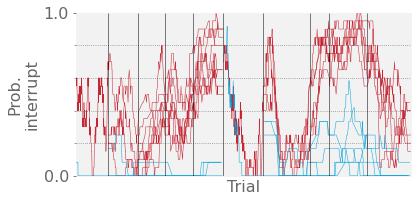

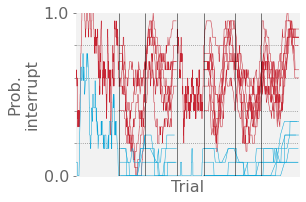

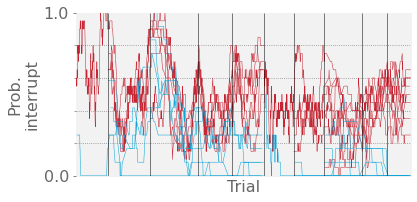

-------------------------   GreWhi2703M   -----------------------


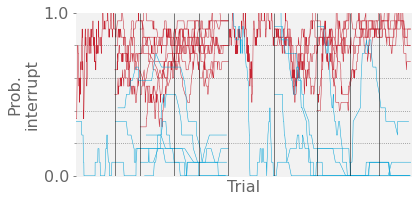

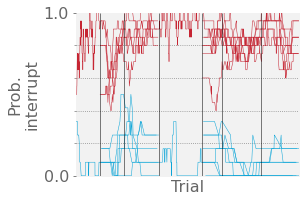

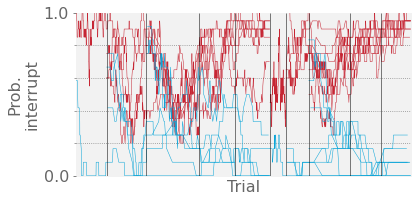

-------------------------   HpiGre8613M   -----------------------


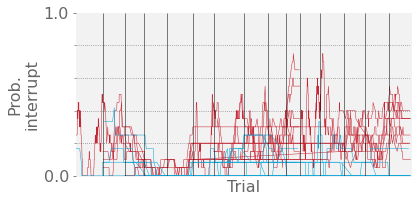

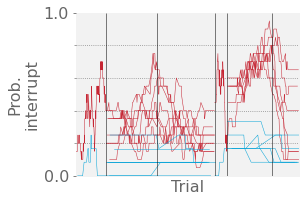

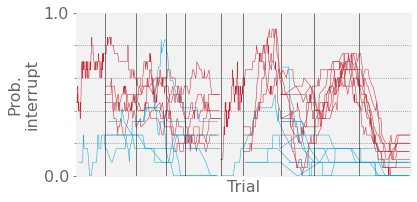

-------------------------   BluGre4315M   -----------------------


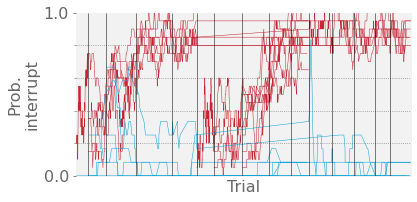

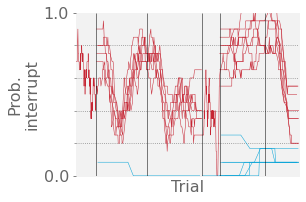

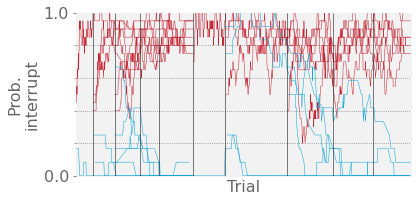

-------------------------   BluRed8773M   -----------------------


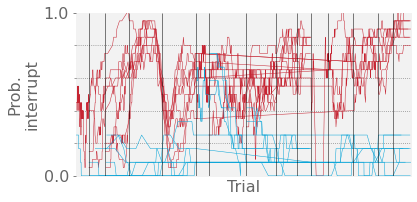

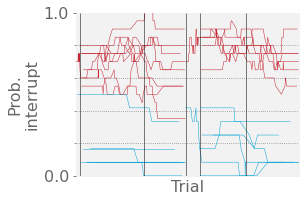

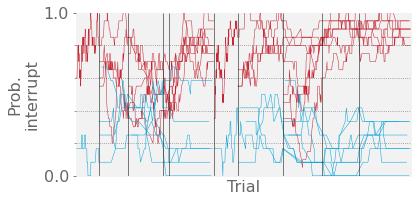

In [22]:
hvcBirds = ['BluWhi0398F', 'BluWhi3230M', 'GraYel7337F', 'GreWhi2703M', 'HpiGre8613M', 'BluGre4315M', 'BluRed8773M']

for bird in hvcBirds:
    print('-------------------------  ', bird, '  -----------------------')
    figure2(bird)  

In [ ]:
SAVE_FIGS = True
figure2("HpiGre0651M")  # Example of HVC lesion with a high performing bird
SAVE_FIGS = False

## Figure 3 and 4

Figures 3 and 4 plot learning curves before and after lesion (as probabilities and as odds ratios).

These figures are generated together here since they were originally one large figure - they have been split into two figures in the latest iteration of the paper.

In [13]:
def figure3a(ax: plt.Axes = None):
    """Plots learning curves for inital learning of S1 stimuli before lesion"""
    if ax is None:
        ax = plt.gca()

    # Get prelesion data (initial learning)
    tsvk = get_or_create_Tsvk(df[
        (df.LesionStage == "prelesion")
        & (df.VocalizerSet == "S1")
    ], k_max=11)

    # Get probability of interruption (avg over subjects) for each k
    p_nore = tsvk.nore.p_by_k()
    p_re = tsvk.re.p_by_k()

    shaded_line(
        p_re["k"], 
        p_re["P_int"], 
        2 * p_re["SE"],
        line_kwargs={"color": color_by_reward.get("Rewarded"), "label": "Re"},
        ax=ax
    )
    
    shaded_line(
        p_nore["k"], 
        p_nore["P_int"], 
        2 * p_nore["SE"],
        line_kwargs={"color": color_by_reward.get("Nonrewarded"), "label": "NoRe"},
        ax=ax
    )

def figure3a_odds(ax: plt.Axes = None):
    """Plots learning curves for inital learning of S1 stimuli before lesion"""
    if ax is None:
        ax = plt.gca()

    # Get prelesion data (initial learning)
    tsvk = get_or_create_Tsvk(df[
        (df.LesionStage == "prelesion")
        & (df.VocalizerSet == "S1")
    ], k_max=11)

    # Get odds-ratio (avg over subjects) for each k
    logOR = tsvk.logOR()

    shaded_line(
        logOR["k"], 
        logOR["logOR"], 
        2 * logOR["SE"],
        ax=ax
    )
    
    pvalues = logOR["pvalue"]
    # first_bin = np.where(false_discovery(pvalues, alpha=0.05))[0][0]
    notSig = ~false_discovery(logOR['pvalue'], alpha=0.05)
    if len(np.where(notSig)[0]):
        first_bin = np.where(notSig)[0][-1]+1
    else:
        first_bin = 0
    
    print("Figure 3A (Bottom)")
    print("------------------")
    print(f"  During the initial exposures to S1")
    print(f"  the smallest bin k where log2OR > 0 could be detected from there on: k={first_bin}")
    print(f"    k=0; logOR = {logOR['logOR'][0]:.2f}, t({logOR['dof'][0]}) = {logOR['tstat'][0]:.2f}, {parse_p(pvalues[0])}")

    # Draw overlay lines showing the logOR of each individual group
    
    for treatment in ["NCM", "HVC", "CTRL"]:
        tsvk_treatment = get_or_create_Tsvk(df[
            (df.LesionStage == "prelesion")
            & (df.VocalizerSet == "S1")
            & (df.SubjectTreatment == treatment)
        ], k_max=11)
        
        logOR = tsvk_treatment.logOR()

        ax.plot(
            logOR["k"], 
            logOR["logOR"], 
            **{
                "linestyle": LINEMAP[treatment],
                "color": COLORMAP[treatment],
                "zorder": -1,
                "linewidth": 1,
            },
        )

def figure3b(ax: plt.Axes = None):
    """Plots learning curves for final stage of ladder before lesion"""
    if ax is None:
        ax = plt.gca()

    # Get prelesion data (late in learning) 
    tsvk = get_or_create_Tsvk(df[
        (df.LesionStage == "prelesion")
        & (df.VocalizerSet == "S1")
        & df.LadderStage.isin(["SovsSo_8v8_d2", "DCvsDC_6v6_d2"])
    ], k_max=11)

    # Get probability of interruption as a function of k
    p_nore = tsvk.nore.p_by_k()
    p_re = tsvk.re.p_by_k()

    shaded_line(
        p_re["k"], 
        p_re["P_int"], 
        2 * p_re["SE"],
        line_kwargs={"color": color_by_reward.get("Rewarded"), "label": "Re"},
        ax=ax
    )
    shaded_line(
        p_nore["k"], 
        p_nore["P_int"], 
        2 * p_nore["SE"],
        line_kwargs={"color": color_by_reward.get("Nonrewarded"), "label": "NoRe"},
        ax=ax
    )

    
def figure3b_odds(ax: plt.Axes = None):
    """Plots learning curves for final stage of ladder before lesion"""
    if ax is None:
        ax = plt.gca()
        
    # Get prelesion data (late in learning) 
    tsvk = get_or_create_Tsvk(df[
        (df.LesionStage == "prelesion")
        & (df.VocalizerSet == "S1")
        & df.LadderStage.isin(["SovsSo_8v8_d2", "DCvsDC_6v6_d2"])
    ], k_max=11)

    # Get odds-ratio (avg over subjects) for each k
    logOR = tsvk.logOR()

    shaded_line(
        logOR["k"], 
        logOR["logOR"], 
        2 * logOR["SE"],
        ax=ax
    )
    
    pvalues = logOR["pvalue"]
    # first_bin = np.where(false_discovery(pvalues, alpha=0.05))[0][0]
    notSig = ~false_discovery(logOR['pvalue'], alpha=0.05)
    if len(np.where(notSig)[0]):
        first_bin = np.where(notSig)[0][-1]+1
    else:
        first_bin = 0
        
    
    print("Figure 3B (Bottom)")
    print("------------------")
    print(f"  On days 6v6-d2/8v8-d2 for pre-lesion learning of S1")
    print(f"  the smallest bin k where log2OR > 0 could be detected from there on: k={first_bin}")
    print(f"    k=0; logOR = {logOR['logOR'][0]:.2f}, t({logOR['dof'][0]}) = {logOR['tstat'][0]:.2f}, {parse_p(pvalues[0])}")

    # Draw overlay lines showing the logOR of each individual group

    for treatment in ["NCM", "HVC", "CTRL"]:
        tsvk_treatment = get_or_create_Tsvk(df[
            (df.LesionStage == "prelesion")
            & (df.VocalizerSet == "S1")
            & (df.SubjectTreatment == treatment)
            & df.LadderStage.isin(["SovsSo_8v8_d2", "DCvsDC_6v6_d2"])
        ], k_max=11)

        logOR = tsvk_treatment.logOR()

        ax.plot(
            logOR["k"], 
            logOR["logOR"], 
            **{
                "linestyle": LINEMAP[treatment],
                "color": COLORMAP[treatment],
                "zorder": -1,
                "linewidth": 1,
            },
        )

In [14]:
def figure4a(treatment: str, ax: plt.Axes = None):
    """Plots learning curves for initial stage of ladder AFTER lesion"""
    if ax is None:
        ax = plt.gca()

    # Get post-lesion data in initial sessions after lesion
    tsvk = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S1")
        & (df.SubjectTreatment == treatment)
    ], k_max=11)

    # Compute probability of interruption as a funciton of k
    p_nore = tsvk.nore.p_by_k()
    p_re = tsvk.re.p_by_k()

    shaded_line(
        p_re["k"], 
        p_re["P_int"], 
        2 * p_re["SE"],
        line_kwargs={"color": color_by_reward.get("Rewarded"), "label": "Re"},
        ax=ax
    )
    shaded_line(
        p_nore["k"], 
        p_nore["P_int"], 
        2 * p_nore["SE"],
        line_kwargs={"color": color_by_reward.get("Nonrewarded"), "label": "NoRe"},
        ax=ax
    )

    
def figure4b(ax: plt.Axes = None):
    """Plots odds ratios of lesioned birds during initial stage of ladder AFTER lesion"""
    if ax is None:
        ax = plt.gca()

    print("Figure 4B")
    print("---------")

    # Overlay odds ratio curves for each treatment type

    for treatment in ["NCM", "HVC", "CTRL", ("HVC", "CTRL")]:
        if isinstance(treatment, str):
            treatment_filter = df.SubjectTreatment == treatment
        elif isinstance(treatment, tuple):
            treatment_filter = np.zeros_like(df.SubjectTreatment).astype(bool)
            for t in treatment:
                treatment_filter |= df.SubjectTreatment == t
                
        tsvk_treatment = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S1")
            & treatment_filter
        ], k_max=11)

        logOR = tsvk_treatment.logOR()
        
        if isinstance(treatment, str):
            shaded_line(
                logOR["k"], 
                logOR["logOR"], 
                2 * logOR["SE"],
                ax=ax,
                line_kwargs={
                    "color": COLORMAP[treatment],
                    "linestyle": LINEMAP[treatment],
                },
            )
        else:
            print(f"Computing combined treatments, {treatment}")
            print(f"==========================================")
        
        pvalues = logOR["pvalue"]
        # first_bin = np.where(false_discovery(pvalues, alpha=0.05))[0][0]
        notSig = ~false_discovery(logOR['pvalue'], alpha=0.05)
        if len(np.where(notSig)[0]):
            first_bin = np.where(notSig)[0][-1]+1
        else:
            first_bin = 0
        
        print(f" The {treatment} group after lesion, being re-exposed to S1")
        print("--------")
        print(f"  the smallest bin k where log2OR > 0 could be detected from there on: k={first_bin}")        

        print(f"    k=0; {treatment}: logOR = {logOR['logOR'][0]:.2f}, t({logOR['dof'][0]}) = {logOR['tstat'][0]:.2f}, {parse_p(pvalues[0])}")
        print(f"    k=1; {treatment}: logOR = {logOR['logOR'][1]:.2f}, t({logOR['dof'][1]}) = {logOR['tstat'][1]:.2f}, {parse_p(pvalues[1])}")
        print()
        
        
def figure4c_data(ax: plt.Axes = None):
    """Generates a table of post-lesion logOR
    """
    post_data = []
    
    # k_array = tuple(np.arange(K_MAX_INITIAL + 1))  # The values of k to compute over

    k_array = tuple(np.arange(10 + 1))  # The values of k to compute over
    for treatment in ["NCM", "HVC", "CTRL"]:
        tsvk_post = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S1")
            & (df.SubjectTreatment == treatment)
        ], k_max=11)
        
        logor_data = tsvk_post.logOR_by_subjects(k=k_array)
        logor_data["Treatment"] = treatment
        
        post_data.append(logor_data)


    tsvk_post = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S1")
        & df.SubjectTreatment.isin(["HVC", "CTRL"])
    ], k_max=11)

    logor_data = tsvk_post.logOR_by_subjects(k=k_array)
    logor_data["Treatment"] = "HVC+CTRL"
    post_data.append(logor_data)

    return pd.concat(post_data)


Figure Dimensions 17.60cm x 6.00cm

Figure 3A (Bottom)
------------------
  During the initial exposures to S1
  the smallest bin k where log2OR > 0 could be detected from there on: k=4
    k=0; logOR = -1.85, t(20) = -3.48, p = 0.999

Figure 3B (Bottom)
------------------
  On days 6v6-d2/8v8-d2 for pre-lesion learning of S1
  the smallest bin k where log2OR > 0 could be detected from there on: k=0
    k=0; logOR = 2.40, t(20) = 3.61, p = 0.001 (***)

Figure 4B
---------
 The NCM group after lesion, being re-exposed to S1
--------
  the smallest bin k where log2OR > 0 could be detected from there on: k=3
    k=0; NCM: logOR = -0.54, t(9) = -0.68, p = 0.742
    k=1; NCM: logOR = 1.04, t(9) = 2.71, p = 0.012 (*)

 The HVC group after lesion, being re-exposed to S1
--------
  the smallest bin k where log2OR > 0 could be detected from there on: k=0
    k=0; HVC: logOR = 1.42, t(6) = 4.05, p = 0.003 (**)
    k=1; HVC: logOR = 3.50, t(6) = 7.41, p < 0.001 (***)

 The CTRL group after lesion

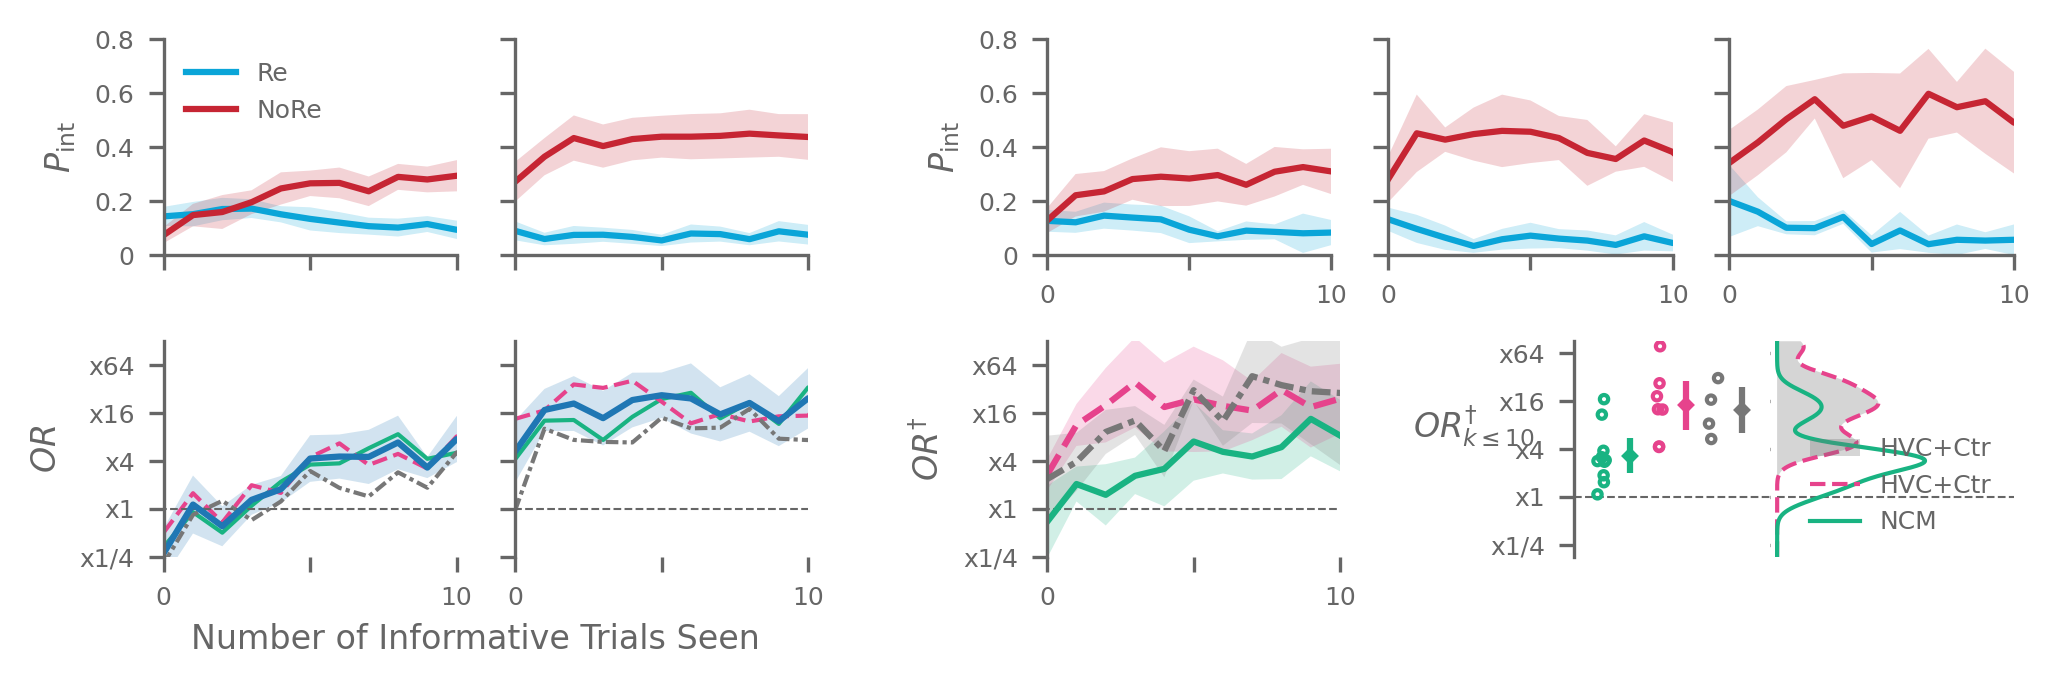

In [15]:
fig = figure_cm(COL2, 6, dpi=300)
print()

hspace = 0.4
wspace = 0.2
gridspec_kw = {"hspace": hspace, "wspace": wspace}

subfigs = fig.subfigures(1, 2, width_ratios=[2, 3])

##########
# 3A, 3B #
##########
axes = subfigs[0].subplots(2, 2, sharex=True, gridspec_kw=gridspec_kw)

figure3a(axes[0, 0])
figure3b(axes[0, 1])
figure3a_odds(axes[1, 0])
print()
figure3b_odds(axes[1, 1])
print()
for ax in axes[0]:
    draw_probability_axes_markers(ax=ax)
for ax in axes[1]:
    draw_logor_axes_markers(smallest=-2, biggest=7, convert_log=False, ax=ax)
    ax.set_ylim(-2, 7)
    border(ax, 1, 0, 0, 0)
for ax in axes[0]:
    ax.tick_params(labelbottom=False)
for ax in axes[:, 1]:
    ax.tick_params(labelleft=False)

for ax in axes.flatten():
    draw_k_axis(k_max=11, ax=ax)
    
axes[0, 0].legend(fontsize=6, loc="upper left", frameon=False)

axes[0, 0].set_ylabel(r"$P_{\mathrm{int}}$", fontsize=8)
axes[1, 0].set_ylabel(r"$OR$", fontsize=8)

subfigs[0].supxlabel("Number of Informative Trials Seen", fontsize=8)
subfigs[0].subplots_adjust(bottom=0.15)

######
# 4A #
######

subfigs_right = subfigs[1].subfigures(1, 1)

# I'm creating a dummy row so that the top row of plots are aligned with the 3A,3B
axes, delete_axes = subfigs_right.subplots(2, 3, sharey=True, gridspec_kw=gridspec_kw)
for ax in delete_axes:
    ax.remove()

figure4a("NCM", ax=axes[0])
figure4a("HVC", ax=axes[1])
figure4a("CTRL", ax=axes[2])

for ax in axes:
    draw_probability_axes_markers(ax=ax)

for ax in axes.flatten():
    draw_k_axis(k_max=11, ax=ax)

axes[0].set_ylabel(r"$P_{\mathrm{int}}$", fontsize=8)

# 4B: Lesioned subject odds ratios
subfigs_bottom = subfigs[1].subfigures(1, 1)
delete_axes, axes = subfigs_bottom.subplots(2, 2, gridspec_kw=dict(width_ratios=[1, 2], **gridspec_kw))
for ax in delete_axes:
    ax.remove()

# Split the remaining space 
last_ax_position = axes[1].get_position()
bounds = last_ax_position.bounds
w = bounds[2]
scatter_ax_bounds = [
    bounds[0] + 1.5 * w/6, 
    bounds[1], 
    2 * w / 6, 
    bounds[3]
]
last_ax_position.x0 = (last_ax_position.x0 + 3.5 * w / 6)
axes[1].set_position(last_ax_position)
ax_scatter = subfigs_bottom.add_axes(scatter_ax_bounds)

# axes[1].sharey(ax_scatter)

######
# 4B #
######
figure4b(ax=axes[0])

draw_logor_axes_markers(smallest=-2, biggest=7, convert_log=False, ax=axes[0])
axes[0].set_ylim(-2, 7)
draw_k_axis(k_max=11, ax=axes[0])
axes[0].set_ylabel(r"$OR^{\dagger}$", fontsize=8)
border(axes[0], 1, 0, 0, 0)


######
# 4C #
######
post = figure4c_data()

post_ncm = post[post["Treatment"] == "NCM"]
post_hvc = post[post["Treatment"] == "HVC"]
post_ctrl = post[post["Treatment"] == "CTRL"]
post_hvc_and_ctrl = post[post["Treatment"] == "HVC+CTRL"]
post = post[post["Treatment"] != "HVC+CTRL"]

ax = axes[1]

merged = True
if (merged):
    smoothhist(np.array(post_hvc_and_ctrl["logOR"]), range=(-2.5, 6.5), bins=20, ax=ax, color=CTRL_COLOR, label="HVC+Ctr", orientation="horizontal", fill=True, alpha=0.3, linewidth=0, linestyle=HVC_LINESTYLE)
    smoothhist(np.array(post_hvc_and_ctrl["logOR"]), range=(-2.5, 6.5), bins=20, ax=ax, color=HVC_COLOR, label="HVC+Ctr", orientation="horizontal", linewidth=1, linestyle=HVC_LINESTYLE)
    smoothhist(np.array(post_ncm["logOR"]), range=(-2.5, 6.5), bins=20, ax=ax, color=NCM_COLOR, label="NCM", orientation="horizontal", linewidth=1, linestyle=NCM_LINESTYLE)
else:
    smoothhist(np.array(post_ctrl["logOR"]), range=(-2.5, 6.5), bins=20, ax=ax, color=CTRL_COLOR, label="Controls", orientation="horizontal", fill=True, alpha=0.3, linewidth=1, linestyle=CTRL_LINESTYLE)
    smoothhist(np.array(post_hvc["logOR"]), range=(-2.5, 6.5), bins=20, ax=ax, color=HVC_COLOR, label="HVC", orientation="horizontal", linewidth=1, linestyle=HVC_LINESTYLE)
    smoothhist(np.array(post_ncm["logOR"]), range=(-2.5, 6.5), bins=20, ax=ax, color=NCM_COLOR, label="NCM", orientation="horizontal", linewidth=1, linestyle=NCM_LINESTYLE)

ax.legend(fontsize=6, loc="lower right", frameon=False)

xlim = ax.get_xlim()
ax.set_xlim(xlim[0], xlim[0] + 1.5 * (xlim[1] - xlim[0]))
ax.set_xticks([], [])
border(ax, 0, 0, 0, 0)
ax.tick_params(labelleft=False, labelbottom=False)
ax.hlines(0, *plt.xlim(), color=AX_COLOR, linestyle="--", linewidth=0.5, zorder=-1)

ax_scatter.scatter(np.random.normal(0, 0.1, len(post_ncm)), post_ncm["logOR"], s=4, linewidth=1, edgecolor=NCM_COLOR, facecolor="none")
ax_scatter.scatter(np.random.normal(2, 0.1, len(post_hvc)), post_hvc["logOR"], s=4, linewidth=1, edgecolor=HVC_COLOR, facecolor="none")
ax_scatter.scatter(np.random.normal(4, 0.1, len(post_ctrl)), post_ctrl["logOR"], s=4, linewidth=1, edgecolor=CTRL_COLOR, facecolor="none")

ax_scatter.errorbar(
    1,
    np.mean(post_ncm["logOR"]), 
    yerr=2 * np.std(post_ncm["logOR"]) / np.sqrt(len(post_ncm)),
    markersize=2,
    marker="D",
    color=NCM_COLOR,
)
ax_scatter.errorbar(
    3,
    np.mean(post_hvc["logOR"]), 
    yerr=2 * np.std(post_hvc["logOR"]) / np.sqrt(len(post_hvc)),
    markersize=2,
    marker="D",
    color=HVC_COLOR,
)
ax_scatter.errorbar(
    5,
    np.mean(post_ctrl["logOR"]), 
    yerr=2 * np.std(post_ctrl["logOR"]) / np.sqrt(len(post_ctrl)),
    markersize=2,
    marker="D",
    color=CTRL_COLOR,
)

ax_scatter.set_xlim(-1, 6)
ax_scatter.hlines(0, *plt.xlim(), color=AX_COLOR, linestyle="--", linewidth=0.5, zorder=-1)
border(ax_scatter, 1, 0, 0, 0)
ax_scatter.set_xticks([])
ax_scatter.set_ylabel(r"$OR^{\dagger}_{k \leq 10}$", fontsize=8, rotation=0)

for ax_ in [ax, ax_scatter]:
    ax_.set_ylim(-2.5, 6.5)
    ax_.set_yticks([ -2, 0, 2, 4, 6], ["x1/4", "x1", "x4", "x16", "x64"], fontsize=6)


if SAVE_FIGS:
    fig.savefig(savedir("fig3.svg"), format="svg", bbox_inches="tight")


In [16]:
fig.savefig(savedir("fig3_new.svg"), format="svg", bbox_inches="tight")

### 4B Stats

In Figure 4B, we test if lesion ("treatment") has an effect on logOR during this early period ($k={0, .., 10}$). To test if treatment is a significant factor, we compare nested linear mixed effects models that include/exclude treatment as a fixed effect.

We then compare the nested models (without treatment or interaction) to the full model (with treatment and interaction) using the likelihood ratio test, defined in `zf_data.stats.likelihood_ratio_test` or using the built-in function f_test from the linear models in statsmodel which can test specific hypothesis starting from the full model.  The two yield identical results when the models converge.  When the models don't converge, we will pick the F-test from the larger model.

The linear mixed effects models here use $k$ as a fixed effect (to account for the general effect of increasing numbers of informative trials), and account for variability in individual subjects as a random effect. In R notation, the nested model is

$\mathrm{logOR}^{\dagger} \sim k + 1|\mathrm{Subject}$

and the full model that includes treatment and the interaction

$\mathrm{logOR}^{\dagger} \sim k + \mathrm{Treatment} + \mathrm{Treatment:k} + 1|\mathrm{Subject}$

Here, Treatment is a categorical variable that can take the value "NCM", "HVC", or "Control".

If we find that Treatment is significant (p < 0.05 for the likelihood ratio test or f_test), then we can do a post-hoc analysis, using the same model comparison but limiting the comparisons to NCM vs HVC, HVC vs Control, and NCM vs Control; the magnitude, direction, and significance of pairwise differences can be quantified with a Wald test. 

In [16]:
def load_treatments_before_d1(treatments=("NCM", "HVC", "CTRL")):
    """Loads the postlesion data in immediate sessions after lesion for one of the treatment groups"""
    logors = []
    for treatment in treatments:
        
        if isinstance(treatment, str):
            treatment_filter = df.SubjectTreatment == treatment
            treatment_name = treatment

        elif isinstance(treatment, tuple):
            treatment_filter = np.zeros_like(df.SubjectTreatment).astype(bool)
            for i,t in enumerate(treatment):
                treatment_filter |= df.SubjectTreatment == t
                if i == 0:
                    treatment_name = t
                else:
                    treatment_name += "+"+t
                
        tsvk = get_or_create_Tsvk(df[
            (df.LesionStage == "prelesion")
            & (df.VocalizerSet == "S1")
            & treatment_filter
        ], k_max=11)

        for i in range(tsvk.k_max):
            logOR = tsvk.logOR_by_subjects(k=i)
            logOR["Treatment"] = treatment_name
            logOR["k"] = i
            logors.append(logOR)

    learning_curve_logors = pd.concat(logors)
    return learning_curve_logors

def load_treatments_before_d2(treatments=("NCM", "HVC", "CTRL")):
    """Loads the postlesion data in immediate sessions after lesion for one of the treatment groups"""
    logors = []
    for treatment in treatments:
        
        if isinstance(treatment, str):
            treatment_filter = df.SubjectTreatment == treatment
            treatment_name = treatment

        elif isinstance(treatment, tuple):
            treatment_filter = np.zeros_like(df.SubjectTreatment).astype(bool)
            for i,t in enumerate(treatment):
                treatment_filter |= df.SubjectTreatment == t
                if i == 0:
                    treatment_name = t
                else:
                    treatment_name += "+"+t
                
        tsvk = get_or_create_Tsvk(df[
            (df.LesionStage == "prelesion")
            & (df.VocalizerSet == "S1")
            & treatment_filter
            & (df.LadderStage.isin(["SovsSo_8v8_d2", "DCvsDC_6v6_d2"]))
            ], k_max=11)

        for i in range(tsvk.k_max):
            logOR = tsvk.logOR_by_subjects(k=i)
            logOR["Treatment"] = treatment_name
            logOR["k"] = i
            logors.append(logOR)

    learning_curve_logors = pd.concat(logors)
    return learning_curve_logors


In [17]:
def load_treatments(treatments=("NCM", "HVC", "CTRL")):
    """Loads the postlesion data in immediate sessions after lesion for one of the treatment groups"""
    logors = []
    for treatment in treatments:
        
        if isinstance(treatment, str):
            treatment_filter = df.SubjectTreatment == treatment
            treatment_name = treatment

        elif isinstance(treatment, tuple):
            treatment_filter = np.zeros_like(df.SubjectTreatment).astype(bool)
            for i,t in enumerate(treatment):
                treatment_filter |= df.SubjectTreatment == t
                if i == 0:
                    treatment_name = t
                else:
                    treatment_name += "+"+t
                
        tsvk = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S1")
            & treatment_filter
        ], k_max=11)

        for i in range(tsvk.k_max):
            logOR = tsvk.logOR_by_subjects(k=i)
            logOR["Treatment"] = treatment_name
            logOR["k"] = i
            logors.append(logOR)

    learning_curve_logors = pd.concat(logors)
    return learning_curve_logors

In [18]:
learning_curve_logors = load_treatments(["NCM", "HVC", "CTRL"])

# Models of interest
k_model = smf.mixedlm(
    "logOR ~ k",
    groups=learning_curve_logors["Subject"],
    data=learning_curve_logors,
    re_formula="~1",
).fit(reml=False)

T_model = smf.mixedlm(
    "logOR ~ Treatment",
    groups=learning_curve_logors["Subject"],
    data=learning_curve_logors,
    re_formula="~1",
).fit(reml=False)

Tandk_model = smf.mixedlm(
    "logOR ~ Treatment + k",
    groups=learning_curve_logors["Subject"],
    data=learning_curve_logors,
    re_formula="~1",
).fit(reml=False)

full_model = smf.mixedlm(
    "logOR ~ Treatment + k + Treatment:k",
    groups=learning_curve_logors["Subject"],
    data=learning_curve_logors,
    re_formula="~1",
).fit(reml=False)

null_model = smf.mixedlm(
    "logOR ~ 1",
    groups=learning_curve_logors["Subject"],
    data=learning_curve_logors,
    re_formula="~1",
).fit(reml=False)

print("Figure 5B Stats Treatment - NCM vs HVC vs CTR")
print("---------------------------------------------")
print()

pvalue, x, dof = likelihood_ratio_test(k_model, full_model)
print('k vs full')
print("---------")
print("We are testing if a model of the learning curves that includes a lesion treatment (3 lines) is a better fit than one without (1 line)")
print()
print("Result:")
print('     f-test:', full_model.f_test('(Treatment[T.NCM]=0), (Treatment[T.NCM]:k=0), (Treatment[T.HVC]=0), (Treatment[T.HVC]:k=0)'))
print(f"    LR: Chi2({dof}) = {x:.2f}, {parse_p(pvalue)}")
print()


pvalue, x, dof = likelihood_ratio_test(k_model, Tandk_model)
print('k vs T+k')
print("--------")
print("We are testing if a model of the learning curves that includes a lesion treatment (3 parallel lines) is a better fit than one without (1 line)")
print()
print("Result:")
print('     f-test:', Tandk_model.f_test('(Treatment[T.NCM]=0), (Treatment[T.HVC]=0)'))
print(f"    LR: Chi2({dof}) = {x:.2f}, {parse_p(pvalue)}")
print()


pvalue, x, dof = likelihood_ratio_test(T_model, full_model)
print('T vs full')
print("--------")
print("We are testing if a model of the learning curves that includes informative trials (3 lines with slopes) is a better fit than one without slope (3 horizontal lines)")
print()
print("Result:")
print('     f-test:', full_model.f_test('(k=0), (Treatment[T.NCM]:k=0), (Treatment[T.HVC]:k=0)'))
print(f"    LR: Chi2({dof}) = {x:.2f}, {parse_p(pvalue)}")
print()


pvalue, x, dof = likelihood_ratio_test(null_model, T_model)
print('Null vs T')
print('---------')
print("We are testing if a model of the learning curves that includes Treatment (3 horizontal lines) is a better fit than one without treatment (1 horizontal line)")
print()
print("Result:")
print('     f-test:', T_model.f_test('(Treatment[T.NCM]=0),(Treatment[T.HVC]=0)'))
print(f"    LR: Chi2({dof}) = {x:.2f}, {parse_p(pvalue)}")
print()


pvalue, x, dof = likelihood_ratio_test(Tandk_model, full_model)
print('T+k vs full')
print('---------')
print("We are testing if a model of the learning curves that includes Treatment and k (3 arbitrary lines) is a better fit than one without 3 parallel lines")
print()
print("Result:")
print('     f-test:', full_model.f_test('(Treatment[T.NCM]:k=0),(Treatment[T.HVC]:k=0)'))
print(f"    Chi2({dof}) = {x:.2f}, {parse_p(pvalue)}")
print()

Figure 5B Stats Treatment - NCM vs HVC vs CTR
---------------------------------------------

k vs full
---------
We are testing if a model of the learning curves that includes a lesion treatment (3 lines) is a better fit than one without (1 line)

Result:
     f-test: <F test: F=5.116606014420606, p=0.0005789212011377577, df_denom=225, df_num=4>
    LR: Chi2(4) = 16.68, p = 0.002 (**)

k vs T+k
--------
We are testing if a model of the learning curves that includes a lesion treatment (3 parallel lines) is a better fit than one without (1 line)

Result:
     f-test: <F test: F=7.542231760754198, p=0.0006740460588761261, df_denom=227, df_num=2>
    LR: Chi2(2) = 11.37, p = 0.003 (**)

T vs full
--------
We are testing if a model of the learning curves that includes informative trials (3 lines with slopes) is a better fit than one without slope (3 horizontal lines)

Result:
     f-test: <F test: F=22.263759938351882, p=1.1627998576607042e-12, df_denom=225, df_num=3>
    LR: Chi2(3) = 57.9

In [19]:
learning_curve_logors = load_treatments(["NCM", ("HVC", "CTRL")])

# Models of interest
k_model = smf.mixedlm(
    "logOR ~ k",
    groups=learning_curve_logors["Subject"],
    data=learning_curve_logors,
    re_formula="~1",
).fit(reml=False)

T_model = smf.mixedlm(
    "logOR ~ Treatment",
    groups=learning_curve_logors["Subject"],
    data=learning_curve_logors,
    re_formula="~1",
).fit(reml=False)

Tandk_model = smf.mixedlm(
    "logOR ~ Treatment + k",
    groups=learning_curve_logors["Subject"],
    data=learning_curve_logors,
    re_formula="~1",
).fit(reml=False)

full_model = smf.mixedlm(
    "logOR ~ Treatment + k + Treatment:k",
    groups=learning_curve_logors["Subject"],
    data=learning_curve_logors,
    re_formula="~1",
).fit(reml=False)

null_model = smf.mixedlm(
    "logOR ~ 1",
    groups=learning_curve_logors["Subject"],
    data=learning_curve_logors,
    re_formula="~1",
).fit(reml=False)

print("Figure 5B Stats Treatment - NCM vs (HVC+CTR) ")
print("---------------------------------------------")
print()

pvalue, x, dof = likelihood_ratio_test(k_model, full_model)
print('k vs full')
print("---------")
print("We are testing if a model of the learning curves that includes a lesion treatment (2 lines) is a better fit than one without (1 line)")
print()
print("Result:")
print('     f-test:', full_model.f_test('(Treatment[T.NCM]=0), (Treatment[T.NCM]:k=0)'))
print(f"    LR: Chi2({dof}) = {x:.2f}, {parse_p(pvalue)}")
print()


pvalue, x, dof = likelihood_ratio_test(k_model, Tandk_model)
print('k vs T+k')
print("--------")
print("We are testing if a model of the learning curves that includes a lesion treatment (2 parallel lines) is a better fit than one without (1 line)")
print()
print("Result:")
print('     f-test:', Tandk_model.f_test('(Treatment[T.NCM]=0)'))
print(f"    LR: Chi2({dof}) = {x:.2f}, {parse_p(pvalue)}")
print()


pvalue, x, dof = likelihood_ratio_test(T_model, full_model)
print('T vs full')
print("--------")
print("We are testing if a model of the learning curves that includes informative trials (2 lines with slopes) is a better fit than one without slope (2 horizontal lines)")
print()
print("Result:")
print('     f-test:', full_model.f_test('(k=0), (Treatment[T.NCM]:k=0)'))
print(f"    LR: Chi2({dof}) = {x:.2f}, {parse_p(pvalue)}")
print()


pvalue, x, dof = likelihood_ratio_test(null_model, T_model)
print('Null vs T')
print('---------')
print("We are testing if a model of the learning curves that includes Treatment (2 horizontal lines) is a better fit than one without treatment (1 horizontal line)")
print()
print("Result:")
print('     f-test:', T_model.f_test('(Treatment[T.NCM]=0)'))
print(f"    LR: Chi2({dof}) = {x:.2f}, {parse_p(pvalue)}")
print()


pvalue, x, dof = likelihood_ratio_test(Tandk_model, full_model)
print('T+k vs full')
print('---------')
print("We are testing if a model of the learning curves that includes Treatment and k (2 arbitrary lines) is a better fit than one without 2 parallel lines")
print()
print("Result:")
print('     f-test:', full_model.f_test('(Treatment[T.NCM]:k=0)'))
print(f"    Chi2({dof}) = {x:.2f}, {parse_p(pvalue)}")
print()

Figure 5B Stats Treatment - NCM vs (HVC+CTR) 
---------------------------------------------

k vs full
---------
We are testing if a model of the learning curves that includes a lesion treatment (2 lines) is a better fit than one without (1 line)

Result:
     f-test: <F test: F=8.440068808732804, p=0.00029134651383054967, df_denom=227, df_num=2>
    LR: Chi2(2) = 12.60, p = 0.002 (**)

k vs T+k
--------
We are testing if a model of the learning curves that includes a lesion treatment (2 parallel lines) is a better fit than one without (1 line)

Result:
     f-test: <F test: F=16.400928631912294, p=7.027649069096849e-05, df_denom=228, df_num=1>
    LR: Chi2(1) = 12.12, p < 0.001 (***)

T vs full
--------
We are testing if a model of the learning curves that includes informative trials (2 lines with slopes) is a better fit than one without slope (2 horizontal lines)

Result:
     f-test: <F test: F=29.53498852670213, p=3.974942787802496e-12, df_denom=227, df_num=2>
    LR: Chi2(2) = 52.

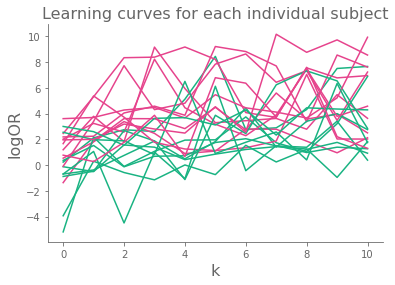

In [20]:
# This figure is not part of the paper
# Just to visualize the data we are fitting to investigate the non-convergence
for subj, subjdf in learning_curve_logors.groupby("Subject"):
    plt.plot(np.arange(11), subjdf["logOR"], color=COLORMAP[subjdf.iloc[0]["Treatment"]])
    plt.xlabel("k", fontsize=16)
    plt.ylabel("logOR", fontsize=16)
plt.title("Learning curves for each individual subject", fontsize=16)
border(plt.gca(), 1, 0, 0, 1)
plt.show()
plt.close(plt.gcf())

In [21]:
learning_curve_logors

,Subject,logOR,Treatment,k
0,GreBlu5039F,-5.194624,NCM,0
1,GreBla3404M,-0.694732,NCM,0
2,GraWhi4040F,-0.127379,NCM,0
3,BlaGre1349M,0.231178,NCM,0
4,XXXHpi0038M,3.004866,NCM,0
...,...,...,...,...
6,GreWhi2703M,4.579624,HVC+CTRL,10
7,HpiGre8613M,2.022368,HVC+CTRL,10
8,BluGre4315M,6.956358,HVC+CTRL,10
9,RedGra7912M,9.938822,HVC+CTRL,10


### Figure 4B post-hoc tests

Thus, lesion has a significant impact on the task performance during the early ($k \le 10$) trials. We next do pairwise tests by including only two treatment conditions and apply the likelihood ratio test, comparing it to the base model.

In [22]:
for comparison in [("NCM", "HVC"), ("NCM", "CTRL"), ("HVC", "CTRL")]:
    learning_curve_logors = load_treatments(comparison)

    base_model = smf.mixedlm(
        "logOR ~ k",
        groups=learning_curve_logors["Subject"],
        data=learning_curve_logors,
        re_formula="1",
    ).fit(reml=False)

    alt_model = smf.mixedlm(
        "logOR ~ Treatment + k",
        groups=learning_curve_logors["Subject"],
        data=learning_curve_logors,
        re_formula="1",
    ).fit(reml=False)

    pvalue, x, dof = likelihood_ratio_test(base_model, alt_model)

    print(f"Testing if intercept of post-lesion S1 learning curves for {comparison[0]} is significantly different from {comparison[1]}?")
    print(f" likelihood ratio test; Chi2({dof}) = {x:.2f}, {parse_p(pvalue)}")
    
    # Wald test
    z = alt_model.tvalues[f"Treatment[T.{comparison[0]}]"]
    p = alt_model.wald_test_terms(scalar=True).table.loc["Treatment", "pvalue"]
    print(f" Wald test ({comparison[1]} - {comparison[0]}); Z = {z:.2f}, {parse_p(p)}")
    print()


Testing if intercept of post-lesion S1 learning curves for NCM is significantly different from HVC?
 likelihood ratio test; Chi2(1) = 8.92, p = 0.003 (**)
 Wald test (HVC - NCM); Z = -3.43, p = 0.001 (***)

Testing if intercept of post-lesion S1 learning curves for NCM is significantly different from CTRL?
 likelihood ratio test; Chi2(1) = 5.96, p = 0.015 (*)
 Wald test (CTRL - NCM); Z = -2.73, p = 0.006 (**)

Testing if intercept of post-lesion S1 learning curves for HVC is significantly different from CTRL?
 likelihood ratio test; Chi2(1) = 0.22, p = 0.642
 Wald test (CTRL - HVC); Z = 0.47, p = 0.641



In [23]:
print(full_model.summary())

            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   logOR    
No. Observations:   231       Method:               ML       
No. Groups:         21        Scale:                3.7572   
Min. group size:    11        Log-Likelihood:       -497.7386
Max. group size:    11        Converged:            Yes      
Mean group size:    11.0                                     
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           2.824    0.485  5.818 0.000  1.873  3.775
Treatment[T.NCM]   -2.612    0.703 -3.713 0.000 -3.990 -1.233
k                   0.282    0.056  5.062 0.000  0.173  0.391
Treatment[T.NCM]:k  0.056    0.081  0.692 0.489 -0.102  0.214
Group Var           1.396    0.290                           



### Figure 4C Stats

Here, we first just want to compare each group against zero - How well are the groups doing relative to chance?

Then we want to see if the groups are different from each other. We do this using an ANOVA (3 way comparison between the groups) as well as a direct comparison between NCM (n=10) and HVC/Controls combined (n=11).

In [24]:
# First we measure the magnitude of performance after lesion for k <= 10 (this can be 10 or 3 see above)
print("Magnitude of postlesion performance on S1 in the k <= 10 window")
for treatment, post_data in [("NCM", post_ncm), ("HVC", post_hvc), ("CTRL", post_ctrl), ("HVC+CTRL", post_hvc_and_ctrl)]:
    logor = np.mean(post_data["logOR"])
    ttest_result = scipy.stats.ttest_1samp(post_data["logOR"], 0)
    print(f" {treatment}: logOR = {logor:.2f}, t({len(post_data) - 1}) = {ttest_result.statistic:.2f}, {parse_p(ttest_result.pvalue)}")

print()
print("The following two tests look for a difference between the groups")
print("1. ANOVA to test for a difference across the three groups")
print("2. Sample sizes matched by combining HVC+CTRL (n=11) to NCM (n=10) and doing a normal t-test")
print()

# ANOVA and Tukeys post-hoc test for differences in postlesion logOR for k <= 3
anova_result = anova_oneway(
    post["logOR"],
    groups=post["Treatment"],
    use_var="equal",
)
print("1. ANOVA result")
print("------------")
print(" A significant difference between the groups was detected")
print(f"  F({anova_result.df_num}, {anova_result.df_denom}) = {anova_result.statistic:.2f}; {parse_p(anova_result.pvalue)}")
print()
tukey = pairwise_tukeyhsd(
    endog=post["logOR"],
    groups=post["Treatment"],
    alpha=0.05)
print(tukey)
print()

# NCM vs HVC+CTRL
print("2. Direct comparison between the (sample size matched) NCM and combined HVC+CTRL")
print("-----------------------------------------------------------------------------------")
ttest_result = scipy.stats.ttest_ind(post_ncm["logOR"], post_hvc_and_ctrl["logOR"])
print(f" {treatment}: t({len(post_ncm) + len(post_hvc_and_ctrl) - 2}) = {ttest_result.statistic:.2f}, {parse_p(ttest_result.pvalue)}")



Magnitude of postlesion performance on S1 in the k <= 10 window
 NCM: logOR = 1.72, t(9) = 4.50, p = 0.001 (**)
 HVC: logOR = 3.82, t(6) = 6.84, p < 0.001 (***)
 CTRL: logOR = 3.62, t(3) = 6.48, p = 0.007 (**)
 HVC+CTRL: logOR = 3.75, t(10) = 9.55, p < 0.001 (***)

The following two tests look for a difference between the groups
1. ANOVA to test for a difference across the three groups
2. Sample sizes matched by combining HVC+CTRL (n=11) to NCM (n=10) and doing a normal t-test

1. ANOVA result
------------
 A significant difference between the groups was detected
  F(2.0, 18.0) = 6.47; p = 0.008 (**)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  CTRL    HVC   0.1951 0.9686 -1.8722  2.2623  False
  CTRL    NCM  -1.9026 0.0567 -3.8538  0.0486  False
   HVC    NCM  -2.0977 0.0107  -3.723 -0.4723   True
----------------------------------------------------

2. Direct compariso

## Figure 4

This is included in the Figure 3 production

## Figure 4 Lower Panels
This figure was figure 5 in the first version of the paper.  The functions called figure5 create that lower panel.

In [25]:
def figure5a(treatment: str, ax: plt.Axes = None):
    """Plots learning curves for learning a new vocalizer set S2"""
    if ax is None:
        ax = plt.gca()

    # Get data from the initial learning of S2
    tsvk = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S2")
        & (df.SubjectTreatment == treatment)
    ], k_max=11)
    
    # Compute probability of interruption as a function of k
    p_nore = tsvk.nore.p_by_k()
    p_re = tsvk.re.p_by_k()

    shaded_line(
        p_re["k"], 
        p_re["P_int"], 
        2 * p_re["SE"],
        line_kwargs={
            "color": color_by_reward.get("Rewarded"), 
            "label": "Re",
        },
        ax=ax
    )
    shaded_line(
        p_nore["k"], 
        p_nore["P_int"], 
        2 * p_nore["SE"],
        line_kwargs={"color": color_by_reward.get("Nonrewarded"), "label": "NoRe"},
        ax=ax
    )

def figure5b(ax: plt.Axes = None):
    """Plots odds-ratios for learning a new vocalizer set S2"""
    if ax is None:
        ax = plt.gca()

    print("Figure 5B")
    print("------------------")

    for treatment in ["NCM", "HVC", "CTRL", ("HVC", "CTRL")]:
        if isinstance(treatment, str):
            treatment_filter = df.SubjectTreatment == treatment
        elif isinstance(treatment, tuple):
            treatment_filter = np.zeros_like(df.SubjectTreatment).astype(bool)
            for t in treatment:
                treatment_filter |= df.SubjectTreatment == t
                
        tsvk_treatment = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S2")
            & treatment_filter
        ], k_max=11)

        logOR = tsvk_treatment.logOR()
        
        if isinstance(treatment, str):
            shaded_line(
                logOR["k"], 
                logOR["logOR"], 
                2 * logOR["SE"],
                ax=ax,
                line_kwargs={
                    "color": COLORMAP[treatment],
                    "linestyle": LINEMAP[treatment],
                },
            )
        else:
            print(f"Computing combined treatments, {treatment}")
            print(f"==========================================")
        
        pvalues = logOR["pvalue"]
        # first_bin = np.where(false_discovery(pvalues, alpha=0.05))[0][0]
        notSig = ~false_discovery(logOR['pvalue'], alpha=0.05)
        if len(np.where(notSig)[0]):
            first_bin = np.where(notSig)[0][-1]+1
        else:
            first_bin = 0
        
        print(f" The {treatment} group after lesion, being exposed to S2")
        print("--------")
        print(f"  the smallest bin k where log2OR > 0 could be detected from there on: k={first_bin}")        

        print(f"    k=0; {treatment}: logOR = {logOR['logOR'][0]:.2f}, t({logOR['dof'][0]}) = {logOR['tstat'][0]:.2f}, {parse_p(pvalues[0])}")
        print(f"    k=1; {treatment}: logOR = {logOR['logOR'][1]:.2f}, t({logOR['dof'][1]}) = {logOR['tstat'][1]:.2f}, {parse_p(pvalues[1])}")
        print()

def figure5c_data(ax: plt.Axes = None):
    """Generates a table of post-lesion logOR
    """
    post_data = []
    
    # k_array = tuple(np.arange(K_MAX_INITIAL + 1))  # The values of k to compute over

    k_array = tuple(np.arange(10 + 1))  # The values of k to compute over
    for treatment in ["NCM", "HVC", "CTRL"]:
        tsvk_post = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S2")
            & (df.SubjectTreatment == treatment)
        ], k_max=11)
        
        logor_data = tsvk_post.logOR_by_subjects(k=k_array)
        logor_data["Treatment"] = treatment
        
        post_data.append(logor_data)


    tsvk_post = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S2")
        & df.SubjectTreatment.isin(["HVC", "CTRL"])
    ], k_max=11)

    logor_data = tsvk_post.logOR_by_subjects(k=k_array)
    logor_data["Treatment"] = "HVC+CTRL"
    post_data.append(logor_data)

    return pd.concat(post_data)



Figure Dimensions 10.60cm x 6.00cm
Figure 5B
------------------
 The NCM group after lesion, being exposed to S2
--------
  the smallest bin k where log2OR > 0 could be detected from there on: k=4
    k=0; NCM: logOR = -0.84, t(9) = -3.53, p = 0.997
    k=1; NCM: logOR = 0.04, t(9) = 0.09, p = 0.463

 The HVC group after lesion, being exposed to S2
--------
  the smallest bin k where log2OR > 0 could be detected from there on: k=9
    k=0; HVC: logOR = -0.70, t(6) = -1.82, p = 0.940
    k=1; HVC: logOR = 0.44, t(6) = 0.86, p = 0.211

 The CTRL group after lesion, being exposed to S2
--------
  the smallest bin k where log2OR > 0 could be detected from there on: k=4
    k=0; CTRL: logOR = -0.63, t(3) = -2.16, p = 0.940
    k=1; CTRL: logOR = 0.77, t(3) = 1.71, p = 0.093

Computing combined treatments, ('HVC', 'CTRL')
 The ('HVC', 'CTRL') group after lesion, being exposed to S2
--------
  the smallest bin k where log2OR > 0 could be detected from there on: k=2
    k=0; ('HVC', 'CTRL'): l

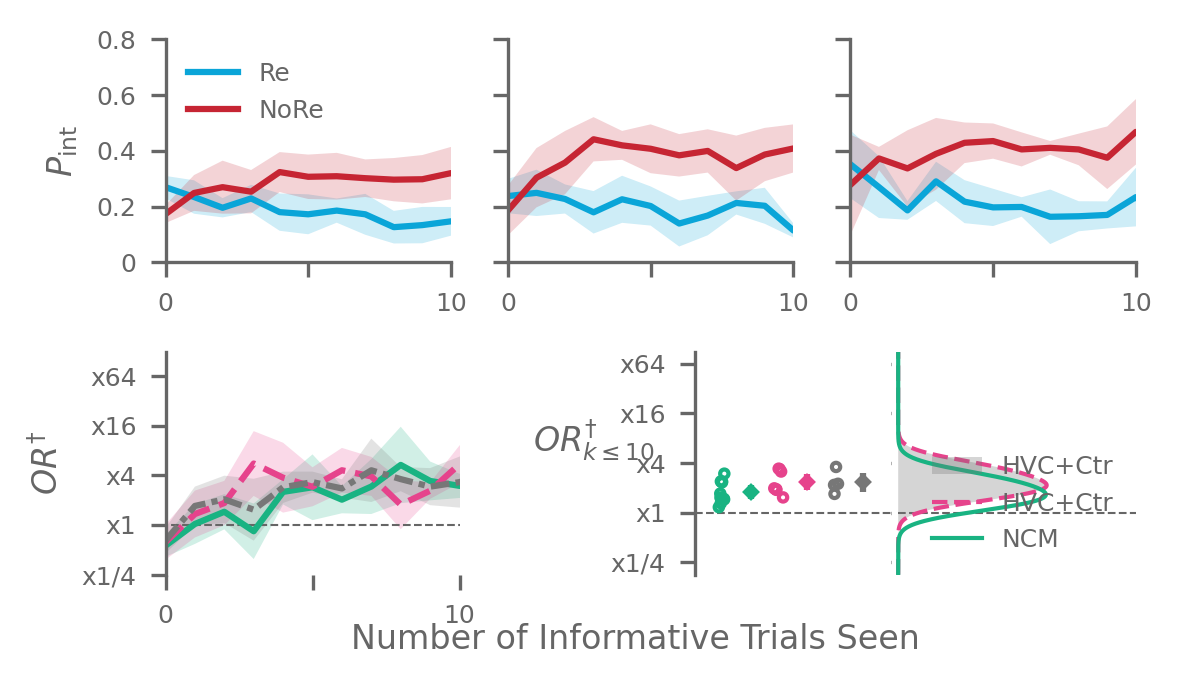

In [26]:
fig = figure_cm(COL1_5 - 1, 6, dpi=300)
hspace = 0.4
wspace = 0.2
gridspec_kw = {"hspace": hspace, "wspace": wspace}
subfigs = [None, fig]

# I'm creating a dummy row so that the top row of plots are aligned with the 3A,3B
axes, delete_axes = subfigs[1].subplots(2, 3, sharey=True, gridspec_kw=gridspec_kw)
for ax in delete_axes:
    ax.remove()


######
# 5A #
######
figure5a("NCM", ax=axes[0])
figure5a("HVC", ax=axes[1])
figure5a("CTRL", ax=axes[2])

for ax in axes:
    draw_probability_axes_markers(ax=ax)

for ax in axes.flatten():
    draw_k_axis(k_max=11, ax=ax)

axes[0].set_ylabel(r"$P_{\mathrm{int}}$", fontsize=8)
axes[0].legend(fontsize=6, loc="upper left", frameon=False)


######
# 5B #
######
# Lesioned subjects learning curves with odds ratios
subfigs_bottom = subfigs[1].subfigures(1, 1)
delete_axes, axes = subfigs_bottom.subplots(2, 2, gridspec_kw=dict(width_ratios=[1, 2], **gridspec_kw))
for ax in delete_axes:
    ax.remove()

figure5b(ax=axes[0])

draw_logor_axes_markers(smallest=-2, biggest=7, convert_log=False, ax=axes[0])
axes[0].set_ylim(-2, 7)
draw_k_axis(k_max=11, ax=axes[0])
axes[0].set_ylabel(r"$OR^{\dagger}$", fontsize=8)
border(axes[0], 1, 0, 0, 0)


fig.supxlabel("Number of Informative Trials Seen", fontsize=8)

######
# 5C #
######
# Split the remaining space 
last_ax_position = axes[1].get_position()
bounds = last_ax_position.bounds
w = bounds[2]
scatter_ax_bounds = [
    bounds[0] + 1.5 * w/6, 
    bounds[1], 
    2 * w / 6, 
    bounds[3]
]
last_ax_position.x0 = (last_ax_position.x0 + 3.5 * w / 6)
axes[1].set_position(last_ax_position)
ax_scatter = subfigs_bottom.add_axes(scatter_ax_bounds)


post = figure5c_data()

post_ncm = post[post["Treatment"] == "NCM"]
post_hvc = post[post["Treatment"] == "HVC"]
post_ctrl = post[post["Treatment"] == "CTRL"]
post_hvc_and_ctrl = post[post["Treatment"] == "HVC+CTRL"]
post = post[post["Treatment"] != "HVC+CTRL"]

ax = axes[1]

merged = True
if (merged):
    smoothhist(np.array(post_hvc_and_ctrl["logOR"]), range=(-2.5, 6.5), bins=20, ax=ax, color=CTRL_COLOR, label="HVC+Ctr", orientation="horizontal", fill=True, alpha=0.3, linewidth=0, linestyle=HVC_LINESTYLE)
    smoothhist(np.array(post_hvc_and_ctrl["logOR"]), range=(-2.5, 6.5), bins=20, ax=ax, color=HVC_COLOR, label="HVC+Ctr", orientation="horizontal", linewidth=1, linestyle=HVC_LINESTYLE)
    smoothhist(np.array(post_ncm["logOR"]), range=(-2.5, 6.5), bins=20, ax=ax, color=NCM_COLOR, label="NCM", orientation="horizontal", linewidth=1, linestyle=NCM_LINESTYLE)
else:
    smoothhist(np.array(post_ctrl["logOR"]), range=(-2.5, 6.5), bins=20, ax=ax, color=CTRL_COLOR, label="Controls", orientation="horizontal", fill=True, alpha=0.3, linewidth=1, linestyle=CTRL_LINESTYLE)
    smoothhist(np.array(post_hvc["logOR"]), range=(-2.5, 6.5), bins=20, ax=ax, color=HVC_COLOR, label="HVC", orientation="horizontal", linewidth=1, linestyle=HVC_LINESTYLE)
    smoothhist(np.array(post_ncm["logOR"]), range=(-2.5, 6.5), bins=20, ax=ax, color=NCM_COLOR, label="NCM", orientation="horizontal", linewidth=1, linestyle=NCM_LINESTYLE)

ax.legend(fontsize=6, loc="lower right", frameon=False)

xlim = ax.get_xlim()
ax.set_xlim(xlim[0], xlim[0] + 1.5 * (xlim[1] - xlim[0]))
ax.set_xticks([], [])
border(ax, 0, 0, 0, 0)
ax.tick_params(labelleft=False, labelbottom=False)
ax.hlines(0, *plt.xlim(), color=AX_COLOR, linestyle="--", linewidth=0.5, zorder=-1)

ax_scatter.scatter(np.random.normal(0, 0.1, len(post_ncm)), post_ncm["logOR"], s=4, linewidth=1, edgecolor=NCM_COLOR, facecolor="none")
ax_scatter.scatter(np.random.normal(2, 0.1, len(post_hvc)), post_hvc["logOR"], s=4, linewidth=1, edgecolor=HVC_COLOR, facecolor="none")
ax_scatter.scatter(np.random.normal(4, 0.1, len(post_ctrl)), post_ctrl["logOR"], s=4, linewidth=1, edgecolor=CTRL_COLOR, facecolor="none")

ax_scatter.errorbar(
    1,
    np.mean(post_ncm["logOR"]), 
    yerr=2 * np.std(post_ncm["logOR"]) / np.sqrt(len(post_ncm)),
    markersize=2,
    marker="D",
    color=NCM_COLOR,
)
ax_scatter.errorbar(
    3,
    np.mean(post_hvc["logOR"]), 
    yerr=2 * np.std(post_hvc["logOR"]) / np.sqrt(len(post_hvc)),
    markersize=2,
    marker="D",
    color=HVC_COLOR,
)
ax_scatter.errorbar(
    5,
    np.mean(post_ctrl["logOR"]), 
    yerr=2 * np.std(post_ctrl["logOR"]) / np.sqrt(len(post_ctrl)),
    markersize=2,
    marker="D",
    color=CTRL_COLOR,
)

ax_scatter.set_xlim(-1, 6)
ax_scatter.hlines(0, *plt.xlim(), color=AX_COLOR, linestyle="--", linewidth=0.5, zorder=-1)
border(ax_scatter, 1, 0, 0, 0)
ax_scatter.set_xticks([])
ax_scatter.set_ylabel(r"$OR^{\dagger}_{k \leq 10}$", fontsize=8, rotation=0)

for ax_ in [ax, ax_scatter]:
    ax_.set_ylim(-2.5, 6.5)
    ax_.set_yticks([ -2, 0, 2, 4, 6], ["x1/4", "x1", "x4", "x16", "x64"], fontsize=6)




if SAVE_FIGS:
    fig.savefig(savedir("fig5.svg"), format="svg", bbox_inches="tight")


In [86]:
fig.savefig(savedir("fig5_new.svg"), format="svg", bbox_inches="tight")

### Figure 5b Stats

We will do the same model comparisons as in Figure 4b; mixed linear models with subject as random effect and k and lesion treatment and their interactions as the fixed effects. The model comparison will be made using the likelihood-ratio test and, equivalently, the F-test.  The two yield identical results when the models converge.  When the models don't converge, we will pick the F-test from the larger model.

In [27]:
def load_treatments_5b(treatments=("NCM", "HVC", "CTRL")):
    """Loads the postlesion data in immediate sessions after lesion for one of the treatment groups"""
    logors = []
    for treatment in treatments:
        
        if isinstance(treatment, str):
            treatment_filter = df.SubjectTreatment == treatment
            treatment_name = treatment

        elif isinstance(treatment, tuple):
            treatment_filter = np.zeros_like(df.SubjectTreatment).astype(bool)
            for i,t in enumerate(treatment):
                treatment_filter |= df.SubjectTreatment == t
                if i == 0:
                    treatment_name = t
                else:
                    treatment_name += '+'+t
                
        tsvk = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S2")
            & treatment_filter
        ], k_max=11)

        for i in range(tsvk.k_max):
            logOR = tsvk.logOR_by_subjects(k=i)
            logOR["Treatment"] = treatment_name
            logOR["k"] = i
            logors.append(logOR)

    learning_curve_logors = pd.concat(logors)
    return learning_curve_logors

In [28]:
learning_curve_logors = load_treatments_5b(["NCM", "HVC", "CTRL"])

# Models of interest
k_model = smf.mixedlm(
    "logOR ~ k",
    groups=learning_curve_logors["Subject"],
    data=learning_curve_logors,
    re_formula="~1",
).fit(reml=False)

T_model = smf.mixedlm(
    "logOR ~ Treatment",
    groups=learning_curve_logors["Subject"],
    data=learning_curve_logors,
    re_formula="~1",
).fit(reml=False)

Tandk_model = smf.mixedlm(
    "logOR ~ Treatment + k",
    groups=learning_curve_logors["Subject"],
    data=learning_curve_logors,
    re_formula="~1",
).fit(reml=False)

full_model = smf.mixedlm(
    "logOR ~ Treatment + k + Treatment:k",
    groups=learning_curve_logors["Subject"],
    data=learning_curve_logors,
    re_formula="~1",
).fit(reml=False)

null_model = smf.mixedlm(
    "logOR ~ 1",
    groups=learning_curve_logors["Subject"],
    data=learning_curve_logors,
    re_formula="~1",
).fit(reml=False)

print("Figure 5B Stats Treatment - NCM vs (HVC+CTR) ")
print("---------------------------------------------")
print()

pvalue, x, dof = likelihood_ratio_test(k_model, full_model)
print('k vs full')
print("---------")
print("We are testing if a model of the learning curves that includes a lesion treatment (3 lines) is a better fit than one without (1 line)")
print()
print("Result:")
print('     f-test:', full_model.f_test('(Treatment[T.NCM]=0), (Treatment[T.NCM]:k=0), (Treatment[T.HVC]=0), (Treatment[T.HVC]:k=0)'))
print(f"    LR: Chi2({dof}) = {x:.2f}, {parse_p(pvalue)}")
print()


pvalue, x, dof = likelihood_ratio_test(k_model, Tandk_model)
print('k vs T+k')
print("--------")
print("We are testing if a model of the learning curves that includes a lesion treatment (3 parallel lines) is a better fit than one without (1 line)")
print()
print("Result:")
print('     f-test:', Tandk_model.f_test('(Treatment[T.NCM]=0), (Treatment[T.HVC]=0)'))
print(f"    LR: Chi2({dof}) = {x:.2f}, {parse_p(pvalue)}")
print()


pvalue, x, dof = likelihood_ratio_test(T_model, full_model)
print('T vs full')
print("--------")
print("We are testing if a model of the learning curves that includes informative trials (3 lines with slopes) is a better fit than one without slope (3 horizontal lines)")
print()
print("Result:")
print('     f-test:', full_model.f_test('(k=0), (Treatment[T.NCM]:k=0), (Treatment[T.HVC]:k=0)'))
print(f"    LR: Chi2({dof}) = {x:.2f}, {parse_p(pvalue)}")
print()


pvalue, x, dof = likelihood_ratio_test(null_model, T_model)
print('Null vs T')
print('---------')
print("We are testing if a model of the learning curves that includes Treatment (3 horizontal lines) is a better fit than one without treatment (1 horizontal line)")
print()
print("Result:")
print('     f-test:', T_model.f_test('(Treatment[T.NCM]=0),(Treatment[T.HVC]=0)'))
print(f"    LR: Chi2({dof}) = {x:.2f}, {parse_p(pvalue)}")
print()


pvalue, x, dof = likelihood_ratio_test(Tandk_model, full_model)
print('T+k vs full')
print('---------')
print("We are testing if a model of the learning curves that includes Treatment and k (3 arbitrary lines) is a better fit than one without 3 parallel lines")
print()
print("Result:")
print('     f-test:', full_model.f_test('(Treatment[T.NCM]:k=0),(Treatment[T.HVC]:k=0)'))
print(f"    Chi2({dof}) = {x:.2f}, {parse_p(pvalue)}")
print()

/Users/frederictheunissen/opt/anaconda3/envs/lesions/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/frederictheunissen/opt/anaconda3/envs/lesions/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/frederictheunissen/opt/anaconda3/envs/lesions/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/frederictheunissen/opt/anaconda3/envs/lesions/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/frederictheunissen/opt/anaconda3/envs/lesions/lib/

Figure 5B Stats Treatment - NCM vs (HVC+CTR) 
---------------------------------------------

k vs full
---------
We are testing if a model of the learning curves that includes a lesion treatment (3 lines) is a better fit than one without (1 line)

Result:
     f-test: <F test: F=1.1691821544024374, p=0.32521187023216563, df_denom=225, df_num=4>
    LR: Chi2(4) = 6.79, p = 0.147

k vs T+k
--------
We are testing if a model of the learning curves that includes a lesion treatment (3 parallel lines) is a better fit than one without (1 line)

Result:
     f-test: <F test: F=1.3558318813382955, p=0.2598118274326353, df_denom=227, df_num=2>
    LR: Chi2(2) = 4.84, p = 0.089

T vs full
--------
We are testing if a model of the learning curves that includes informative trials (3 lines with slopes) is a better fit than one without slope (3 horizontal lines)

Result:
     f-test: <F test: F=19.212713629596212, p=3.968001852575334e-11, df_denom=225, df_num=3>
    LR: Chi2(3) = 50.93, p < 0.001 (**

In [29]:
# Fitting lines 

treatments = ["NCM", "HVC", "CTRL", ("HVC","CTRL")]
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

for treatment in treatments:
    # S1 Pre Lesion - first learning
    learning_curve_logors = load_treatments_before_d1([treatment])
    k_model = smf.mixedlm(
        "logOR ~ k",
        groups=learning_curve_logors["Subject"],
        data=learning_curve_logors,
        re_formula="~1",
    ).fit()
    if isinstance(treatment, str):
        treatment_name = treatment
    elif isinstance(treatment, tuple):
        for i,t in enumerate(treatment):
            if i == 0:
                treatment_name = t
            else:
                treatment_name += '+'+t
    label = pd.Series(['S1d1-'+treatment_name, 'S1d1-'+treatment_name], index = ['Intercept', 'k'])
    lineDF = pd.concat([label, k_model.fe_params, k_model.bse_fe], axis=1)
    lineDF.columns = ['Treat.', 'Coef.', 'SE']
    display(lineDF.style.format(precision=2))
    
    # S1 Pre Lesion - second learning
    learning_curve_logors = load_treatments_before_d2([treatment])
    k_model = smf.mixedlm(
        "logOR ~ k",
        groups=learning_curve_logors["Subject"],
        data=learning_curve_logors,
        re_formula="~1",
    ).fit()
    if isinstance(treatment, str):
        treatment_name = treatment
    elif isinstance(treatment, tuple):
        for i,t in enumerate(treatment):
            if i == 0:
                treatment_name = t
            else:
                treatment_name += '+'+t
    label = pd.Series(['S1d2-'+treatment_name, 'S1d2-'+treatment_name], index = ['Intercept', 'k'])
    lineDF = pd.concat([label, k_model.fe_params, k_model.bse_fe], axis=1)
    lineDF.columns = ['Treat.', 'Coef.', 'SE']
    display(lineDF.style.format(precision=2))
    
    # S1 Post Lession
    learning_curve_logors = load_treatments([treatment])
    k_model = smf.mixedlm(
        "logOR ~ k",
        groups=learning_curve_logors["Subject"],
        data=learning_curve_logors,
        re_formula="~1",
    ).fit()
    if isinstance(treatment, str):
        treatment_name = treatment
    elif isinstance(treatment, tuple):
        for i,t in enumerate(treatment):
            if i == 0:
                treatment_name = t
            else:
                treatment_name += '+'+t
    label = pd.Series(['S1-'+treatment_name, 'S1-'+treatment_name], index = ['Intercept', 'k'])
    lineDF = pd.concat([label, k_model.fe_params, k_model.bse_fe], axis=1)
    lineDF.columns = ['Treat.', 'Coef.', 'SE']
    display(lineDF.style.format(precision=2))

    
    # S2 Post Lesion
    learning_curve_logors = load_treatments_5b([treatment])
    k_model = smf.mixedlm(
        "logOR ~ k",
        groups=learning_curve_logors["Subject"],
        data=learning_curve_logors,
        re_formula="~1",
    ).fit()
    if isinstance(treatment, str):
        treatment_name = treatment
    elif isinstance(treatment, tuple):
        for i,t in enumerate(treatment):
            if i == 0:
                treatment_name = t
            else:
                treatment_name += '+'+t
    label = pd.Series(['S2-'+treatment_name, 'S2-'+treatment_name], index = ['Intercept', 'k'])
    lineDF = pd.concat([label, k_model.fe_params, k_model.bse_fe], axis=1)
    lineDF.columns = ['Treat.', 'Coef.', 'SE']
    display(lineDF.style.format(precision=2))




,Treat.,Coef.,SE
Intercept,S1d1-NCM,-0.98,0.40
k,S1d1-NCM,0.42,0.06


,Treat.,Coef.,SE
Intercept,S1d2-NCM,2.98,0.56
k,S1d2-NCM,0.18,0.06


,Treat.,Coef.,SE
Intercept,S1-NCM,0.21,0.50
k,S1-NCM,0.34,0.05


,Treat.,Coef.,SE
Intercept,S2-NCM,-0.30,0.31
k,S2-NCM,0.25,0.04


,Treat.,Coef.,SE
Intercept,S1d1-HVC,-0.34,0.43
k,S1d1-HVC,0.33,0.06


,Treat.,Coef.,SE
Intercept,S1d2-HVC,4.67,0.66
k,S1d2-HVC,-0.08,0.06


,Treat.,Coef.,SE
Intercept,S1-HVC,3.30,0.67
k,S1-HVC,0.17,0.07


,Treat.,Coef.,SE
Intercept,S2-HVC,0.55,0.31
k,S2-HVC,0.17,0.05


/Users/frederictheunissen/opt/anaconda3/envs/lesions/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/frederictheunissen/opt/anaconda3/envs/lesions/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


,Treat.,Coef.,SE
Intercept,S1d1-CTRL,-1.05,0.40
k,S1d1-CTRL,0.31,0.07


,Treat.,Coef.,SE
Intercept,S1d2-CTRL,2.09,0.63
k,S1d2-CTRL,0.17,0.07


,Treat.,Coef.,SE
Intercept,S1-CTRL,1.94,0.63
k,S1-CTRL,0.37,0.08


,Treat.,Coef.,SE
Intercept,S2-CTRL,0.33,0.29
k,S2-CTRL,0.19,0.05


,Treat.,Coef.,SE
Intercept,S1d1-HVC+CTRL,-0.70,0.36
k,S1d1-HVC+CTRL,0.35,0.05


,Treat.,Coef.,SE
Intercept,S1d2-HVC+CTRL,3.92,0.55
k,S1d2-HVC+CTRL,0.00,0.06


,Treat.,Coef.,SE
Intercept,S1-HVC+CTRL,2.82,0.53
k,S1-HVC+CTRL,0.28,0.06


,Treat.,Coef.,SE
Intercept,S2-HVC+CTRL,0.49,0.23
k,S2-HVC+CTRL,0.17,0.04


In [30]:
learning_curve_logors = load_treatments_5b(["NCM", ("HVC", "CTRL")])

# Models of interest
k_model = smf.mixedlm(
    "logOR ~ k",
    groups=learning_curve_logors["Subject"],
    data=learning_curve_logors,
    re_formula="~1",
).fit(reml=False)

T_model = smf.mixedlm(
    "logOR ~ Treatment",
    groups=learning_curve_logors["Subject"],
    data=learning_curve_logors,
    re_formula="~1",
).fit(reml=False)

Tandk_model = smf.mixedlm(
    "logOR ~ Treatment + k",
    groups=learning_curve_logors["Subject"],
    data=learning_curve_logors,
    re_formula="~1",
).fit(reml=False)

full_model = smf.mixedlm(
    "logOR ~ Treatment + k + Treatment:k",
    groups=learning_curve_logors["Subject"],
    data=learning_curve_logors,
    re_formula="~1",
).fit(reml=False)

null_model = smf.mixedlm(
    "logOR ~ 1",
    groups=learning_curve_logors["Subject"],
    data=learning_curve_logors,
    re_formula="~1",
).fit(reml=False)

print("Figure 5B Stats Treatment - NCM vs (HVC+CTR) ")
print("---------------------------------------------")
print()

pvalue, x, dof = likelihood_ratio_test(k_model, full_model)
print('k vs full')
print("---------")
print("We are testing if a model of the learning curves that includes a lesion treatment (2 lines) is a better fit than one without (1 line)")
print()
print("Result:")
print('     f-test:', full_model.f_test('(Treatment[T.NCM]=0), (Treatment[T.NCM]:k=0)'))
print(f"    LR: Chi2({dof}) = {x:.2f}, {parse_p(pvalue)}")
print()


pvalue, x, dof = likelihood_ratio_test(k_model, Tandk_model)
print('k vs T+k')
print("--------")
print("We are testing if a model of the learning curves that includes a lesion treatment (2 parallel lines) is a better fit than one without (1 line)")
print()
print("Result:")
print('     f-test:', Tandk_model.f_test('(Treatment[T.NCM]=0)'))
print(f"    LR: Chi2({dof}) = {x:.2f}, {parse_p(pvalue)}")
print()


pvalue, x, dof = likelihood_ratio_test(T_model, full_model)
print('T vs full')
print("--------")
print("We are testing if a model of the learning curves that includes informative trials (2 lines with slopes) is a better fit than one without slope (2 horizontal lines)")
print()
print("Result:")
print('     f-test:', full_model.f_test('(k=0), (Treatment[T.NCM]:k=0)'))
print(f"    LR: Chi2({dof}) = {x:.2f}, {parse_p(pvalue)}")
print()


pvalue, x, dof = likelihood_ratio_test(null_model, T_model)
print('Null vs T')
print('---------')
print("We are testing if a model of the learning curves that includes Treatment (2 horizontal lines) is a better fit than one without treatment (1 horizontal line)")
print()
print("Result:")
print('     f-test:', T_model.f_test('(Treatment[T.NCM]=0)'))
print(f"    LR: Chi2({dof}) = {x:.2f}, {parse_p(pvalue)}")
print()


pvalue, x, dof = likelihood_ratio_test(Tandk_model, full_model)
print('T+k vs full')
print('---------')
print("We are testing if a model of the learning curves that includes Treatment and k (2 arbitrary lines) is a better fit than one without 2 parallel lines")
print()
print("Result:")
print('     f-test:', full_model.f_test('(Treatment[T.NCM]:k=0)'))
print(f"    Chi2({dof}) = {x:.2f}, {parse_p(pvalue)}")
print()

Figure 5B Stats Treatment - NCM vs (HVC+CTR) 
---------------------------------------------

k vs full
---------
We are testing if a model of the learning curves that includes a lesion treatment (2 lines) is a better fit than one without (1 line)

Result:
     f-test: <F test: F=2.2731178681723576, p=0.10533022221236006, df_denom=227, df_num=2>
    LR: Chi2(2) = 6.80, p = 0.033 (*)

k vs T+k
--------
We are testing if a model of the learning curves that includes a lesion treatment (2 parallel lines) is a better fit than one without (1 line)

Result:
     f-test: <F test: F=2.612921158141101, p=0.10737911426220963, df_denom=228, df_num=1>
    LR: Chi2(1) = 4.88, p = 0.027 (*)

T vs full
--------
We are testing if a model of the learning curves that includes informative trials (2 lines with slopes) is a better fit than one without slope (2 horizontal lines)

Result:
     f-test: <F test: F=27.68532583094712, p=1.7414666959267436e-11, df_denom=227, df_num=2>
    LR: Chi2(2) = 49.15, p < 0

The k model did not converge, but the full model converged.  Thus we used the f-test using the results from the full model instead of the likelihood ratio test.

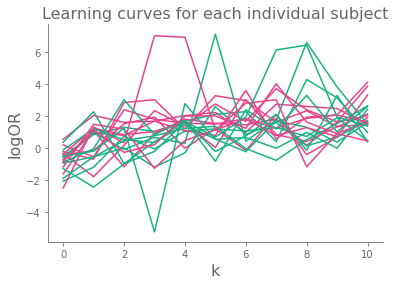

In [31]:
# This figure is not part of the paper
# Just to visualize the data we are fitting to investigate the non-convergence
for subj, subjdf in learning_curve_logors.groupby("Subject"):
    plt.plot(np.arange(11), subjdf["logOR"], color=COLORMAP[subjdf.iloc[0]["Treatment"]])
    plt.xlabel("k", fontsize=16)
    plt.ylabel("logOR", fontsize=16)
plt.title("Learning curves for each individual subject", fontsize=16)
border(plt.gca(), 1, 0, 0, 1)
plt.show()
plt.close(plt.gcf())

In [32]:
# Figure 5C (now on second row of 4C)
# First we measure the magnitude of performance after lesion for k <= 10 (this can be 10 or 3 see above)
print("Magnitude of postlesion performance on S2 in the k <= 10 window")
for treatment, post_data in [("NCM", post_ncm), ("HVC", post_hvc), ("CTRL", post_ctrl), ("HVC+CTRL", post_hvc_and_ctrl)]:
    logor = np.mean(post_data["logOR"])
    ttest_result = scipy.stats.ttest_1samp(post_data["logOR"], 0)
    print(f" {treatment}: logOR = {logor:.2f}, t({len(post_data) - 1}) = {ttest_result.statistic:.2f}, {parse_p(ttest_result.pvalue)}")

print()
print("The following two tests look for a difference between the groups")
print("1. ANOVA to test for a difference across the three groups")
print("2. Sample sizes matched by combining HVC+CTRL (n=11) to NCM (n=10) and doing a normal t-test")
print()

# ANOVA and Tukeys post-hoc test for differences in postlesion logOR for k <= 3
anova_result = anova_oneway(
    post["logOR"],
    groups=post["Treatment"],
    use_var="equal",
)
print("1. ANOVA result")
print("------------")
print(" A significant difference between the groups was not detected")
print(f"  F({anova_result.df_num}, {anova_result.df_denom}) = {anova_result.statistic:.2f}; {parse_p(anova_result.pvalue)}")
print()
tukey = pairwise_tukeyhsd(
    endog=post["logOR"],
    groups=post["Treatment"],
    alpha=0.05)
print(tukey)
print()

# NCM vs HVC+CTRL
print("2. Direct comparison between the (sample size matched) NCM and combined HVC+CTRL")
print("-----------------------------------------------------------------------------------")
ttest_result = scipy.stats.ttest_ind(post_ncm["logOR"], post_hvc_and_ctrl["logOR"])
print(f" {treatment}: t({len(post_ncm) + len(post_hvc_and_ctrl) - 2}) = {ttest_result.statistic:.2f}, {parse_p(ttest_result.pvalue)}")




Magnitude of postlesion performance on S2 in the k <= 10 window
 NCM: logOR = 0.84, t(9) = 5.81, p < 0.001 (***)
 HVC: logOR = 1.23, t(6) = 6.82, p < 0.001 (***)
 CTRL: logOR = 1.22, t(3) = 5.37, p = 0.013 (*)
 HVC+CTRL: logOR = 1.23, t(10) = 9.12, p < 0.001 (***)

The following two tests look for a difference between the groups
1. ANOVA to test for a difference across the three groups
2. Sample sizes matched by combining HVC+CTRL (n=11) to NCM (n=10) and doing a normal t-test

1. ANOVA result
------------
 A significant difference between the groups was not detected
  F(2.0, 18.0) = 1.89; p = 0.180

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  CTRL    HVC   0.0146 0.9986 -0.7255 0.7547  False
  CTRL    NCM  -0.3832 0.3618 -1.0818 0.3154  False
   HVC    NCM  -0.3978 0.2164 -0.9797 0.1841  False
---------------------------------------------------

2. Direct comparison betwee

In [33]:
def s2d2_data(ax: plt.Axes = None, k_max = 11):
    """Generates a table of post-lesion logOR
    """
    post_data = []
    
    # k_array = tuple(np.arange(K_MAX_INITIAL + 1))  # The values of k to compute over

    k_array = tuple(np.arange(k_max))  # The values of k to compute over
    for treatment in ["NCM", "HVC", "CTRL"]:
        tsvk_post = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S2")
            & (df.SubjectTreatment == treatment)
            & df.LadderStage.isin(["DCvsDC_6v6_d2_S2", "SovsSo_8v8_d2_S2"])
        ], k_max = k_max)
        
        logor_data = tsvk_post.logOR_by_subjects(k=k_array)
        logor_data["Treatment"] = treatment
        
        post_data.append(logor_data)


    tsvk_post = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S2")
        & df.SubjectTreatment.isin(["HVC", "CTRL"])
        & df.LadderStage.isin(["DCvsDC_6v6_d2_S2", "SovsSo_8v8_d2_S2"])
    ], k_max = k_max)

    logor_data = tsvk_post.logOR_by_subjects(k=k_array)
    logor_data["Treatment"] = "HVC+CTRL"
    post_data.append(logor_data)

    return pd.concat(post_data)

In [34]:
post = s2d2_data(k_max = 1001)

post_ncm = post[post["Treatment"] == "NCM"]
post_hvc = post[post["Treatment"] == "HVC"]
post_ctrl = post[post["Treatment"] == "CTRL"]
post_hvc_and_ctrl = post[post["Treatment"] == "HVC+CTRL"]
post = post[post["Treatment"] != "HVC+CTRL"]

print("Magnitude of postlesion performance on S2 for day 2")
for treatment, post_data in [("NCM", post_ncm), ("HVC", post_hvc), ("CTRL", post_ctrl), ("HVC+CTRL", post_hvc_and_ctrl)]:
    logor = np.mean(post_data["logOR"])
    ttest_result = scipy.stats.ttest_1samp(post_data["logOR"], 0)
    print(f" {treatment}: logOR = {logor:.2f}, t({len(post_data) - 1}) = {ttest_result.statistic:.2f}, {parse_p(ttest_result.pvalue)}")

print()
print("The following two tests look for a difference between the groups")
print("1. ANOVA to test for a difference across the three groups")
print("2. Sample sizes matched by combining HVC+CTRL (n=11) to NCM (n=10) and doing a normal t-test")
print()

# ANOVA and Tukeys post-hoc test for differences in postlesion logOR 
anova_result = anova_oneway(
    post["logOR"],
    groups=post["Treatment"],
    use_var="equal",
)
print("1. ANOVA result")
print("------------")
print(" A significant difference between the groups was not detected")
print(f"  F({anova_result.df_num}, {anova_result.df_denom}) = {anova_result.statistic:.2f}; {parse_p(anova_result.pvalue)}")
print()
tukey = pairwise_tukeyhsd(
    endog=post["logOR"],
    groups=post["Treatment"],
    alpha=0.05)
print(tukey)
print()

# NCM vs HVC+CTRL
print("2. Direct comparison between the (sample size matched) NCM and combined HVC+CTRL")
print("-----------------------------------------------------------------------------------")
ttest_result = scipy.stats.ttest_ind(post_ncm["logOR"], post_hvc_and_ctrl["logOR"])
print(f" {treatment}: t({len(post_ncm) + len(post_hvc_and_ctrl) - 2}) = {ttest_result.statistic:.2f}, {parse_p(ttest_result.pvalue)}")




Magnitude of postlesion performance on S2 for day 2
 NCM: logOR = 2.20, t(9) = 4.08, p = 0.003 (**)
 HVC: logOR = 4.32, t(6) = 7.31, p < 0.001 (***)
 CTRL: logOR = 3.26, t(3) = 3.96, p = 0.029 (*)
 HVC+CTRL: logOR = 3.93, t(10) = 8.14, p < 0.001 (***)

The following two tests look for a difference between the groups
1. ANOVA to test for a difference across the three groups
2. Sample sizes matched by combining HVC+CTRL (n=11) to NCM (n=10) and doing a normal t-test

1. ANOVA result
------------
 A significant difference between the groups was not detected
  F(2.0, 18.0) = 3.43; p = 0.055

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  CTRL    HVC   1.0612 0.5698 -1.5754  3.6977  False
  CTRL    NCM  -1.0606 0.5336 -3.5492   1.428  False
   HVC    NCM  -2.1218 0.0444 -4.1947 -0.0488   True
----------------------------------------------------

2. Direct comparison between the 

In [35]:
post = s2d2_data(k_max = 51)

post_ncm = post[post["Treatment"] == "NCM"]
post_hvc = post[post["Treatment"] == "HVC"]
post_ctrl = post[post["Treatment"] == "CTRL"]
post_hvc_and_ctrl = post[post["Treatment"] == "HVC+CTRL"]
post = post[post["Treatment"] != "HVC+CTRL"]

print("Magnitude of postlesion performance on S2 for day 2")
for treatment, post_data in [("NCM", post_ncm), ("HVC", post_hvc), ("CTRL", post_ctrl), ("HVC+CTRL", post_hvc_and_ctrl)]:
    logor = np.mean(post_data["logOR"])
    ttest_result = scipy.stats.ttest_1samp(post_data["logOR"], 0)
    print(f" {treatment}: logOR = {logor:.2f}, t({len(post_data) - 1}) = {ttest_result.statistic:.2f}, {parse_p(ttest_result.pvalue)}")

print()
print("The following two tests look for a difference between the groups")
print("1. ANOVA to test for a difference across the three groups")
print("2. Sample sizes matched by combining HVC+CTRL (n=11) to NCM (n=10) and doing a normal t-test")
print()

# ANOVA and Tukeys post-hoc test for differences in postlesion logOR 
anova_result = anova_oneway(
    post["logOR"],
    groups=post["Treatment"],
    use_var="equal",
)
print("1. ANOVA result")
print("------------")
print(" A significant difference between the groups was not detected")
print(f"  F({anova_result.df_num}, {anova_result.df_denom}) = {anova_result.statistic:.2f}; {parse_p(anova_result.pvalue)}")
print()
tukey = pairwise_tukeyhsd(
    endog=post["logOR"],
    groups=post["Treatment"],
    alpha=0.05)
print(tukey)
print()

# NCM vs HVC+CTRL
print("2. Direct comparison between the (sample size matched) NCM and combined HVC+CTRL")
print("-----------------------------------------------------------------------------------")
ttest_result = scipy.stats.ttest_ind(post_ncm["logOR"], post_hvc_and_ctrl["logOR"])
print(f" {treatment}: t({len(post_ncm) + len(post_hvc_and_ctrl) - 2}) = {ttest_result.statistic:.2f}, {parse_p(ttest_result.pvalue)}")

# Effect size
meanNCM = np.mean(post_ncm["logOR"])
meanCTRL = np.mean(post_hvc_and_ctrl["logOR"])
    
# normalization term
nNCM = len(post_ncm.index)
nCTRL = len(post_hvc_and_ctrl.index)
varNCM = np.var(post_ncm["logOR"]) 
varCTRL = np.var(post_hvc_and_ctrl['logOR'])
norm_var = np.sqrt((varNCM * nNCM + varCTRL * nCTRL) / (nNCM + nCTRL-2))

# effect size of NCM lesion on memory
d_prime = (np.sqrt(2) * (meanCTRL-meanNCM)) / norm_var

print(f"Effect size d\'={d_prime:.2f} Mean NCM={meanNCM:.2f} Mean HVC+CTRL={meanCTRL:.2f}")



Magnitude of postlesion performance on S2 for day 2
 NCM: logOR = 2.12, t(9) = 3.84, p = 0.004 (**)
 HVC: logOR = 4.26, t(6) = 7.15, p < 0.001 (***)
 CTRL: logOR = 3.25, t(3) = 3.87, p = 0.031 (*)
 HVC+CTRL: logOR = 3.89, t(10) = 8.01, p < 0.001 (***)

The following two tests look for a difference between the groups
1. ANOVA to test for a difference across the three groups
2. Sample sizes matched by combining HVC+CTRL (n=11) to NCM (n=10) and doing a normal t-test

1. ANOVA result
------------
 A significant difference between the groups was not detected
  F(2.0, 18.0) = 3.35; p = 0.058

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  CTRL    HVC   1.0122 0.6109 -1.6802  3.7046  False
  CTRL    NCM  -1.1253 0.5086 -3.6666   1.416  False
   HVC    NCM  -2.1375 0.0476 -4.2544 -0.0206   True
----------------------------------------------------

2. Direct comparison between the 

In [36]:
        tsvk_post = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S2")
            & (df.SubjectTreatment == 'NCM')
            & df.LadderStage.isin(["DCvsDC_6v6_d2_S2", "SovsSo_8v8_d2_S2"])
        ], k_max = 100)

In [37]:

grouped_df = tsvk_post.df.groupby("Subject") 
maximums = grouped_df.max() 
maximums = maximums.reset_index()
print(maximums['Subject'], maximums['RelInformativeTrialsSeen'])

0    BlaGre1349M
1    GraWhi4040F
2    GreBla3404M
3    GreBlu5039F
4    HpiGre0651M
5    RedHpi0710F
6    WhiBlu5805F
7    XXXBlu0031M
8    XXXHpi0038M
9    XXXOra0037F
Name: Subject, dtype: object 0     74
1     80
2    126
3     89
4    143
5    129
6    148
7    133
8     58
9     85
Name: RelInformativeTrialsSeen, dtype: int64


## Figure 6

Plotting the overall performance on new (S2) stimuli

In [38]:
def figure_6(treatment: str, call_type: str = None, ax: plt.Axes = None):
    """Plot the overall odds ratios when the stimuli are well learned
    """
    if ax is None:
        ax = plt.gca()
        
    colormap = {
        "NCM": NCM_COLOR,
        "HVC": HVC_COLOR,
        "CTRL": CTRL_COLOR
    }
    
    if call_type is None:
        call_type_filter = np.ones_like(df.StimulusCallType).astype(bool)
    else:
        call_type_filter = df.StimulusCallType == call_type

    tsvk_S1_pre = get_or_create_Tsvk(df[
        (df.LesionStage == "prelesion")
        & (df.VocalizerSet == "S1")
        & (df.SubjectTreatment == treatment)
        & call_type_filter
        & df.LadderStage.isin(["DCvsDC_6v6_d2", "SovsSo_8v8_d2"])
    ])
    tsvk_S1_post = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S1")
        & (df.SubjectTreatment == treatment)
        & call_type_filter
        & df.LadderStage.isin(["DCvsDC_6v6_d2", "SovsSo_8v8_d2"])
    ])
    tsvk_S2_post = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S2")
        & (df.SubjectTreatment == treatment)
        & call_type_filter
        & df.LadderStage.isin(["DCvsDC_6v6_d2_S2", "SovsSo_8v8_d2_S2"])
    ])
        
    scores_1 = tsvk_S1_pre.fisher_exact_by_subjects(side="greater")
    scores_2 = tsvk_S1_post.fisher_exact_by_subjects(side="greater")
    scores_3 = tsvk_S2_post.fisher_exact_by_subjects(side="greater")
    
    mean_1 = np.mean(scores_1["logOR"])
    mean_2 = np.mean(scores_2["logOR"])
    mean_3 = np.mean(scores_3["logOR"])
    
    sem_1 = np.std(scores_1["logOR"]) / np.sqrt(len(scores_1))
    sem_2 = np.std(scores_2["logOR"]) / np.sqrt(len(scores_2))
    sem_3 = np.std(scores_3["logOR"]) / np.sqrt(len(scores_3))

    ax.plot([0, 1, 2], np.array([scores_1["logOR"], scores_2["logOR"], scores_3["logOR"]]), alpha=1, linewidth=1, color="0.8")

    ax.scatter(0 * np.ones(len(scores_1)), scores_1["logOR"], s=3, linewidth=1, alpha=1, facecolor="none", edgecolor="0.8")
    ax.scatter(1 * np.ones(len(scores_2)), scores_2["logOR"], s=3, linewidth=1, alpha=1, facecolor="none", edgecolor="0.8")
    ax.scatter(2 * np.ones(len(scores_3)), scores_3["logOR"], s=3, linewidth=1, alpha=1, facecolor="none", edgecolor="0.8")
    
    dof = len(scores_1) - 1

    print(" Paired t-test results to see if scores after lesion were different than before lesion:")
    print("  S1' - S1")
    tstat, pvalue = scipy.stats.ttest_rel(scores_2["logOR"], scores_1["logOR"], alternative='two-sided')
    diff = np.mean(scores_2['logOR'] - scores_1['logOR'])
    dprime = np.sqrt(2)*diff/np.std(scores_2['logOR'] - scores_1['logOR'])
    print(f"   t({dof}) = {tstat:.2f}, {parse_p(pvalue)}")
    print(f"   diff = {diff:.2f}")
    print(f"   d-prime = {dprime:.2f}")
    
    print("  S2' - S1")
    tstat, pvalue = scipy.stats.ttest_rel(scores_3["logOR"], scores_1["logOR"], alternative='two-sided')
    diff = np.mean(scores_3['logOR'] - scores_1['logOR'])
    dprime = np.sqrt(2)*diff/np.std(scores_3['logOR'] - scores_1['logOR'])
    print(f"   t({dof}) = {tstat:.2f}, {parse_p(pvalue)}")
    print(f"   diff = {diff:.2f}")
    print(f"   d-prime = {dprime:.2f}")
    
    print()
    print(" One-sample t-test for logOR > 0:")
    dof = len(scores_1) - 1
    print("  S1")
    tstat, pvalue = scipy.stats.ttest_1samp(scores_1["logOR"], 0, alternative="greater")
    print(f"   logOR = {np.mean(scores_1['logOR']):.2f}, t({dof}) = {tstat:.2f}, {parse_p(pvalue)}")

    print("  S1'")
    dof = len(scores_2) - 1
    tstat, pvalue = scipy.stats.ttest_1samp(scores_2["logOR"], 0, alternative="greater")
    print(f"   logOR = {np.mean(scores_2['logOR']):.2f}, t({dof}) = {tstat:.2f}, {parse_p(pvalue)}")

    print("  S2'")
    dof = len(scores_3) - 1
    tstat, pvalue = scipy.stats.ttest_1samp(scores_3["logOR"], 0, alternative="greater")
    print(f"   logOR = {np.mean(scores_3['logOR']):.2f}, t({dof}) = {tstat:.2f}, {parse_p(pvalue)}")

    print()
    ax.errorbar(
        [0.1, 1.1, 2.1], 
        [mean_1, mean_2, mean_3], 
        2 * np.array([sem_1, sem_2, sem_3]),
        linewidth=1.5, markersize=4, markerfacecolor="white", color=colormap[treatment], marker="d")
    
    

Figure Dimensions 7.50cm x 4.00cm
 NCM
--------
 Paired t-test results to see if scores after lesion were different than before lesion:
  S1' - S1
   t(9) = -3.60, p = 0.006 (**)
   diff = -1.77
   d-prime = -1.70
  S2' - S1
   t(9) = -3.45, p = 0.007 (**)
   diff = -1.85
   d-prime = -1.63

 One-sample t-test for logOR > 0:
  S1
   logOR = 3.87, t(9) = 8.45, p < 0.001 (***)
  S1'
   logOR = 2.11, t(9) = 4.99, p < 0.001 (***)
  S2'
   logOR = 2.02, t(9) = 4.00, p = 0.002 (**)

 HVC
--------
 Paired t-test results to see if scores after lesion were different than before lesion:
  S1' - S1
   t(6) = -1.94, p = 0.101
   diff = -0.50
   d-prime = -1.12
  S2' - S1
   t(6) = -1.06, p = 0.330
   diff = -0.34
   d-prime = -0.61

 One-sample t-test for logOR > 0:
  S1
   logOR = 4.53, t(6) = 7.83, p < 0.001 (***)
  S1'
   logOR = 4.03, t(6) = 9.27, p < 0.001 (***)
  S2'
   logOR = 4.19, t(6) = 7.15, p < 0.001 (***)

 CTRL
--------
 Paired t-test results to see if scores after lesion were differ

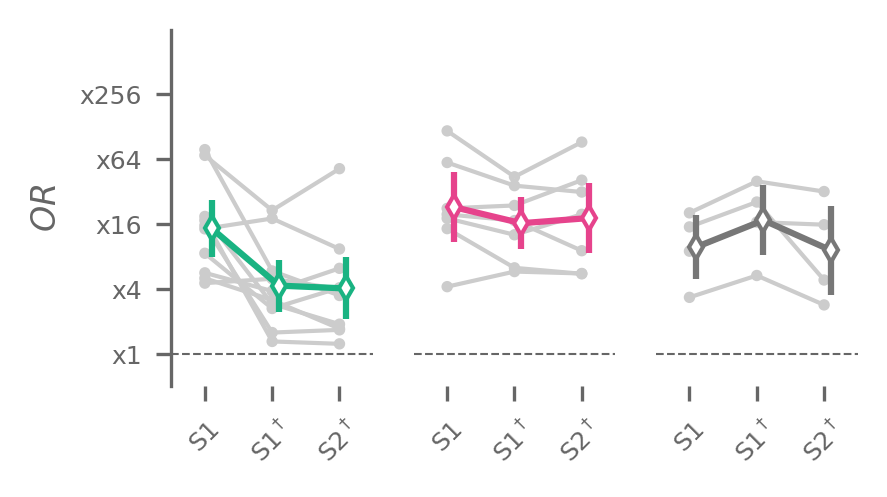

In [39]:
fig = figure_cm(COL1 - 1, 4, dpi=300)
axes = fig.subplots(1, 3)

print(" NCM")
print("--------")
figure_6("NCM", ax=axes[0])

print(" HVC")
print("--------")
figure_6("HVC", ax=axes[1])

print(" CTRL")
print("--------")
figure_6("CTRL", ax=axes[2])

for ax in axes:
    border(ax, 1)
    ax.set_xlim(-0.5, 2.5)

for ax in axes:
    draw_logor_axes_markers(smallest=-2, biggest=8, convert_log=False, ax=ax)
    ax.set_ylim(-1, 10)
    border(ax, 1)
    
for ax in axes[1:]:
    border(ax)
    ax.set_yticks([])
    
for ax in axes[1:]:
    ax.tick_params(labelleft=False)

axes[0].set_ylabel("$OR$", fontsize=8)

for ax in axes:
    ax.set_xticks(
        [0, 1, 2],
        ["S1", "S1$^\dagger$", "S2$^\dagger$"],
        rotation=45,
        fontsize=6)

if SAVE_FIGS:
    fig.savefig(savedir("fig6.svg"), format="svg", bbox_inches="tight")


## Figure 7

Lesion size analysis on memory effect

In [96]:
lesion_summary_table = load_lesion_summary_table()

In [97]:
lesion_summary_table

,Subject,L-CD (mm^3),L-CV (mm^3),L-RD (mm^3),L-RV (mm^3),R-CD (mm^3),R-CV (mm^3),R-RD (mm^3),R-RV (mm^3),TotalVolume (mm^3),HP,L,NCL,Cb,CM,HVC
0,BlaGre1349M,0.099476,0.000000,0.111854,0.000000,0.405746,0.031751,0.000000,0.000000,0.648828,1,0,1,0,0,0
1,XXXBlu0031M,0.134680,0.043486,0.182173,0.052694,0.000000,0.000000,0.099761,0.106353,0.619148,0,1,1,0,1,0
2,HpiGre0651M,0.096018,0.120710,0.140431,0.027856,0.139041,0.121493,0.206499,0.066585,0.918634,0,0,1,0,1,1
3,GreBla3404M,0.377925,0.132724,0.008446,0.000000,0.015056,0.058582,0.000000,0.000000,0.592733,1,0,0,0,0,0
4,GreBlu5039F,0.115266,0.025727,0.192688,0.000000,0.051460,0.008768,0.000000,0.000000,0.393909,2,1,0,1,1,0
5,WhiBlu5805F,0.091170,0.025224,0.202312,0.005355,0.013773,0.000000,0.296019,0.000000,0.633853,0,2,3,0,1,0
6,RedHpi0710F,0.028780,0.046094,0.101825,0.004671,0.009868,0.027441,0.092718,0.078331,0.389727,1,0,2,0,1,1
7,XXXOra0037F,0.035109,0.325156,0.000000,0.000000,0.056495,0.126573,0.017544,0.131676,0.692553,0,0,2,0,0,0
8,XXXHpi0038M,0.089552,0.003205,0.062383,0.000000,0.075883,0.000000,0.000000,0.000000,0.231024,2,0,0,1,0,0
9,GraWhi4040F,0.012917,0.013011,0.000000,0.000000,0.165030,0.127069,0.003658,0.000000,0.321686,0,0,0,0,0,0


In [98]:
def get_lesion_size(subject):
    if np.any(lesion_summary_table.Subject == subject):
        return lesion_summary_table[lesion_summary_table.Subject == subject].iloc[0]["TotalVolume (mm^3)"]
    else:
        return 0.0

In [99]:
def figure_7(call_type: str, ax: plt.Axes = None):
    """Create a scatter plot between NCM lesion size and change in logOR before and after lesion
    
    Also fit a best fit line just to the NCM points
    """
    if ax is None:
        ax = plt.gca()
        
    for treatment in ["NCM", "HVC", "CTRL"]:
        tsvk_S1_pre = get_or_create_Tsvk(df[
            (df.LesionStage == "prelesion")
            & (df.VocalizerSet == "S1")
            & (df.StimulusCallType == call_type)
            & (df.SubjectTreatment == treatment)
            & df.LadderStage.isin(["DCvsDC_6v6_d2", "SovsSo_8v8_d2"])
        ])
        tsvk_S1_post = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S1")
            & (df.StimulusCallType == call_type)
            & (df.SubjectTreatment == treatment)
            & df.LadderStage.isin(["DCvsDC_6v6_d2", "SovsSo_8v8_d2"])
        ])
        
        scores_1 = tsvk_S1_pre.fisher_exact_by_subjects(side="greater")
        scores_2 = tsvk_S1_post.fisher_exact_by_subjects(side="greater")
        assert np.all(scores_1["Subject"] == scores_2["Subject"])
        delta = scores_2["logOR"] - scores_1["logOR"]
        
        lesion_sizes = [get_lesion_size(subject) for subject in scores_1["Subject"]]
        
        ax.scatter(
            lesion_sizes,
            delta,
            s=30,
            linewidth=1,
            facecolor="none",
            label=treatment,
            edgecolor=COLORMAP[treatment]
        )
        
        if treatment == "NCM":
            x_data = lesion_sizes
            y_data = delta

            x_data = sm.add_constant(x_data)
            result = statsmodels.regression.linear_model.OLS(y_data, x_data)
            r = np.corrcoef(x_data[:, 1], y_data)[0, 1]
            result = result.fit()
            print(f"Best fit line to NCM data ({call_type})")
            print("-------------------------")
            
            print(f" r = {r:.2f}, F({result.df_model:.0f}, {result.df_resid:.0f}) = {result.fvalue:.2f} {parse_p(result.f_pvalue)}, R2_adj = {result.rsquared_adj:.2f}")
            print()
            
            x = np.linspace(-0.1, 1.1, num=3)
            ax.plot(x, result.params[0] + result.params[1] * x, linewidth=1, color=NCM_COLOR, linestyle="--", zorder=-1)

            pvalue = result.pvalues[1]
            r2_adj = result.rsquared_adj
            ax.text(
                0.04,
                0.02, 
                "$R^2_{adj}$" + f"={r2_adj:.2f}\n" + "$p=$" + f"{pvalue:.2f}",
                fontsize=8, 
                verticalalignment="bottom",
                horizontalalignment="left",
                color=NCM_COLOR,
                transform=ax.transAxes
            )

#### Compare the slopes of the lines



Figure Dimensions 10.60cm x 5.00cm

Best fit line to NCM data (SO)
-------------------------
 r = -0.28, F(1, 8) = 0.70 p = 0.426, R2_adj = -0.03

Best fit line to NCM data (DC)
-------------------------
 r = -0.50, F(1, 8) = 2.72 p = 0.138, R2_adj = 0.16



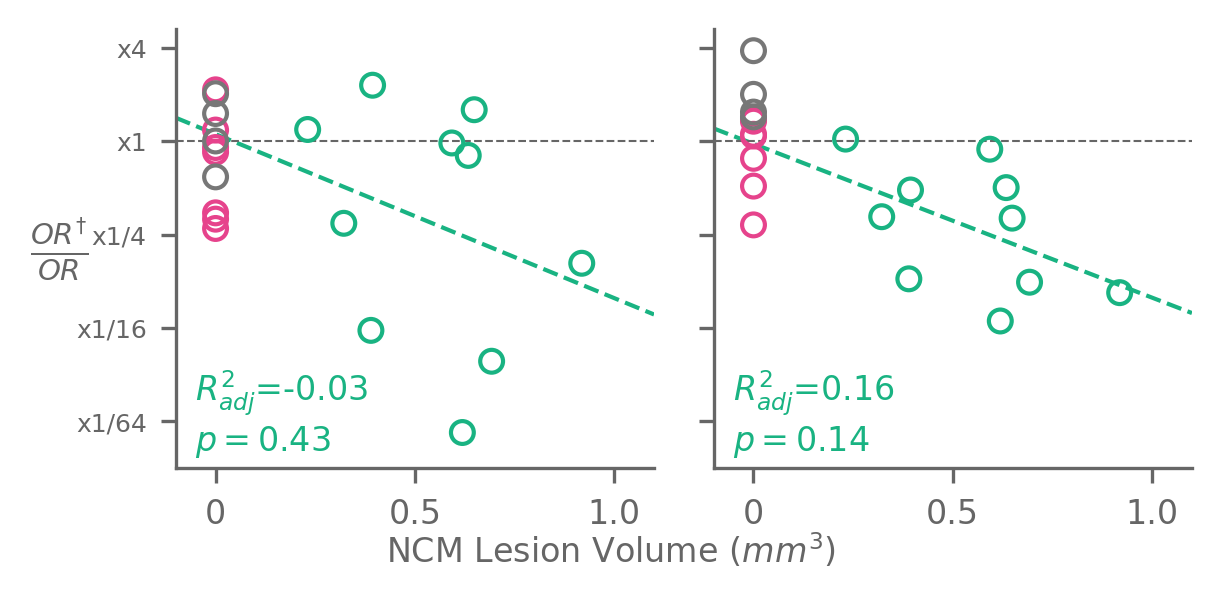

In [100]:
fig = figure_cm(COL1_5 - 1, 5, dpi=300)

print()
axes = fig.subplots(1, 2, sharey=True)#  gridspec_kw={"hspace": 1.0})
figure_7("SO", ax=axes[0])
figure_7("DC", ax=axes[1])

axes[0].set_ylabel(r"$\frac{OR^{\dagger}}{OR}$", fontsize=10, verticalalignment="center", rotation=0)

for ax in axes:
    ax.set_xlim(-0.1, 1.1)
    border(ax, 1, 0, 0, 1)
    draw_logor_axes_markers(smallest=-7, biggest=2, convert_log=False, ax=ax)
    ax.set_ylim(-7, 2.4)
    ax.set_xticks([0, 0.5, 1.0], [0, 0.5, 1.0], fontsize=8)

fig.tight_layout()
fig.supxlabel("NCM Lesion Volume ($mm^3$)", fontsize=8)

if SAVE_FIGS:
    fig.savefig(savedir("fig7.svg"), format="svg", bbox_inches="tight")
